In [23]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import StratifiedKFold, train_test_split, cross_val_predict
from sklearn.metrics import (accuracy_score, precision_score, recall_score, 
                            f1_score, roc_auc_score, precision_recall_curve, 
                            average_precision_score, confusion_matrix)
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as imbPipeline 
from imblearn.pipeline import make_pipeline as make_imb_pipeline
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.ensemble import (RandomForestClassifier, GradientBoostingClassifier,
                             VotingClassifier)
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.feature_selection import SelectFromModel, SelectKBest, f_classif
import matplotlib.pyplot as plt
from sklearn.calibration import calibration_curve
import joblib
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

# Set style for better looking plots
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = [12, 8]

In [24]:
df = pd.read_csv('train_data.csv')
test_df = pd.read_csv('test_data.csv')

In [25]:
len(test_df)

4467

In [26]:
df.columns

Index(['id', 'Birth_Date', 'Weight', 'Height', 'Urban_Rural', 'Occupation',
       'Insurance_Type', 'Family_History', 'Cancer_Type', 'Stage_at_Diagnosis',
       'Diagnosis_Date', 'Symptoms', 'Tumor_Size', 'Surgery_Date',
       'Chemotherapy_Drugs', 'Radiation_Sessions', 'Immunotherapy',
       'Targeted_Therapy', 'Recurrence_Status', 'Smoking_History',
       'Alcohol_Use', 'label'],
      dtype='object')

In [27]:
df.head()

,id,Birth_Date,Weight,Height,Urban_Rural,Occupation,Insurance_Type,Family_History,Cancer_Type,Stage_at_Diagnosis,...,Tumor_Size,Surgery_Date,Chemotherapy_Drugs,Radiation_Sessions,Immunotherapy,Targeted_Therapy,Recurrence_Status,Smoking_History,Alcohol_Use,label
0,1,1994-07-01,64.9,155.0cm,Urban,Unemployed,UEBMI,No,Breast,II,...,8.0,2024-10-19,"Paclitaxel,Docetaxel,Doxorubicin",16,No,Yes,NO,Never,Regular,1
1,2,1992-07-16,61.4,171.0cm,Urban,Factory Worker,UEBMI,Yes,Breast,I,...,10.0,2021-02-28,"Cyclophosphamide,Paclitaxel,Doxorubicin,Docetaxel",10,No,No,Yes,Former,Regular,1
2,3,1948-06-23,60.7,170.0cm,Rural,Unemployed,NRCMS,No,Stomach,IV,...,13.0,2022-09-25,"Fluorouracil,Cisplatin",21,Yes,No,NO,Former,Never,0
3,4,1954-11-26,70.2,171.0cm,Urban,Farmer,URBMI,Yes,Cervical,IV,...,3.0,2024-09-13,Cisplatin,10,No,Yes,NO,Never,Regular,1
4,5,1979-07-08,100.3,186.0cm,Rural,Office Worker,Self-pay,Yes,Lung,II,...,12.0,2023-12-08,"Gemcitabine,Carboplatin",6,Yes,No,Yes,Former,Never,0


In [28]:
df.isna().sum()

id                       0
Birth_Date               0
Weight                   0
Height                   0
Urban_Rural              0
Occupation               0
Insurance_Type           0
Family_History           0
Cancer_Type              0
Stage_at_Diagnosis       0
Diagnosis_Date           0
Symptoms               501
Tumor_Size               0
Surgery_Date          7575
Chemotherapy_Drugs    4050
Radiation_Sessions       0
Immunotherapy            0
Targeted_Therapy         0
Recurrence_Status        0
Smoking_History          0
Alcohol_Use              0
label                    0
dtype: int64

In [29]:
def show_unique_values(df):
    for column in ['Urban_Rural', 'Occupation',
       'Insurance_Type', 'Family_History', 'Cancer_Type', 'Stage_at_Diagnosis',
       'Radiation_Sessions', 'Immunotherapy',
       'Targeted_Therapy', 'Recurrence_Status', 'Smoking_History',
       'Alcohol_Use', 'label']:
        unique_vals = df[column].unique()
        print(f"Column: {column}")
        print(f"Unique Values: {unique_vals}")

# Run the function
show_unique_values(df)

Column: Urban_Rural
Unique Values: ['Urban' 'Rural']
Column: Occupation
Unique Values: ['Unemployed' 'Factory Worker' 'Farmer' 'Office Worker' 'Retired']
Column: Insurance_Type
Unique Values: ['UEBMI' 'NRCMS' 'URBMI' 'Self-pay']
Column: Family_History
Unique Values: ['No' 'Yes']
Column: Cancer_Type
Unique Values: ['Breast' 'Stomach' 'Cervical' 'Lung' 'Esophageal' 'Colorectal' 'Liver']
Column: Stage_at_Diagnosis
Unique Values: ['II' 'I' 'IV' 'III']
Column: Radiation_Sessions
Unique Values: [16 10 21  6 13  4 26 14  7 28  1  0  5 19 27 25 18 17 15 12  8  3  9 24
 11  2 20 23 29 22]
Column: Immunotherapy
Unique Values: ['No' 'Yes']
Column: Targeted_Therapy
Unique Values: ['Yes' 'No']
Column: Recurrence_Status
Unique Values: ['NO' 'Yes']
Column: Smoking_History
Unique Values: ['Never' 'Former' 'Current']
Column: Alcohol_Use
Unique Values: ['Regular' 'Never' 'Occasional']
Column: label
Unique Values: [1 0]


# Preprocessing

In [30]:
# Convert dates to datetime
df['Birth_Date'] = pd.to_datetime(df['Birth_Date'], format='%Y-%m-%d', errors='coerce')
df['Diagnosis_Date'] = pd.to_datetime(df['Diagnosis_Date'], format='%Y-%m-%d', errors='coerce')
df['Surgery_Date'] = pd.to_datetime(df['Surgery_Date'], format='%Y-%m-%d', errors='coerce')

# Check for illogical dates (diagnosis before birth)
invalid_age_mask = df['Diagnosis_Date'] < df['Birth_Date']
print("Illogical dates (diagnosis before birth):", invalid_age_mask.sum())

# Fix the calculate_age function to handle NaTs
def safe_calculate_age(born, diagnosed):
    if pd.isna(born) or pd.isna(diagnosed):
        return np.nan
    if diagnosed < born:  # Diagnosis before birth
        return np.nan
    return diagnosed.year - born.year - ((diagnosed.month, diagnosed.day) < (born.month, born.day))

# Recalculate age
df['Age_at_Diagnosis'] = df.apply(lambda x: safe_calculate_age(x['Birth_Date'], x['Diagnosis_Date']), axis=1)

# Check how many are still missing
df[df['Age_at_Diagnosis'].isna()]

Illogical dates (diagnosis before birth): 0


,id,Birth_Date,Weight,Height,Urban_Rural,Occupation,Insurance_Type,Family_History,Cancer_Type,Stage_at_Diagnosis,...,Surgery_Date,Chemotherapy_Drugs,Radiation_Sessions,Immunotherapy,Targeted_Therapy,Recurrence_Status,Smoking_History,Alcohol_Use,label,Age_at_Diagnosis
238,239,NaT,90.1,163.0cm,Urban,Factory Worker,NRCMS,No,Breast,I,...,2022-07-25,"Cisplatin, Paclitaxel",15,No,No,Yes,Current,Never,0,NaN
889,890,NaT,92.9,189.0cm,Rural,Farmer,URBMI,No,Lung,I,...,2017-12-24,Gemcitabine,17,Yes,No,Yes,Former,Occasional,0,NaN
1005,1006,NaT,58.9,183.0cm,Urban,Office Worker,UEBMI,Yes,Stomach,I,...,2015-07-28,"Cisplatin, Paclitaxel",13,No,No,Yes,Never,Never,1,NaN
1560,1561,NaT,57.9,166.0cm,Rural,Factory Worker,NRCMS,No,Breast,III,...,2023-05-20,"Paclitaxel,Cyclophosphamide",15,No,No,Yes,Former,Never,1,NaN
1953,1954,NaT,67.4,158.0cm,Rural,Retired,URBMI,Yes,Stomach,IV,...,2022-09-18,"Cisplatin,Fluorouracil",7,Yes,Yes,Yes,Never,Occasional,0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25019,25020,NaT,51.7,182.0cm,Urban,Farmer,URBMI,Yes,Esophageal,II,...,NaT,"Gemcitabine, Carboplatin",18,No,No,NO,Former,Regular,1,NaN
25230,25231,NaT,37.2,156.0cm,Rural,Office Worker,Self-pay,No,Esophageal,II,...,NaT,NaN,0,No,Yes,NO,Former,Occasional,1,NaN
25688,25689,NaT,80.4,183.0cm,Rural,Retired,UEBMI,No,Breast,III,...,NaT,NaN,20,No,No,Yes,Never,Occasional,0,NaN
25985,25986,NaT,54.5,160.0cm,Rural,Retired,URBMI,No,Breast,I,...,NaT,"Gemcitabine, Carboplatin",14,Yes,No,Yes,Never,Never,1,NaN


In [31]:
age_median = df['Age_at_Diagnosis'].median()
df['Age_at_Diagnosis'].fillna(age_median, inplace=True)

In [32]:
# Create IBM
df['Height'] = df['Height'].str.replace('cm', '').astype(float) / 100
df['BMI'] = df['Weight'] / (df['Height'] ** 2)
df['BMI'] = df['BMI'].round(2) 

In [33]:
# Create surgery delay (days between diagnosis and surgery)
df['Surgery_Delay'] = (df['Surgery_Date'] - df['Diagnosis_Date']).dt.days

# Create had_surgery indicator
df['Had_Surgery'] = df['Surgery_Date'].notna().astype(int)

# Create had_chemotherapy indicator
df['Had_Chemotherapy'] = df['Chemotherapy_Drugs'].notna().astype(int)

# Create symptom count
df['Symptom_Count'] = df['Symptoms'].apply(lambda x: len(x.split(',')) if isinstance(x, str) else 0)

# Create drug count
df['Drug_Count'] = df['Chemotherapy_Drugs'].apply(lambda x: len(x.split(',')) if isinstance(x, str) else 0)

In [34]:
stage_map = {'I': 1, 'II': 2, 'III': 3, 'IV': 4}
df['Stage_Ordinal'] = df['Stage_at_Diagnosis'].map(stage_map)

In [35]:
## 1. For Chemotherapy Drugs ##

# Split drugs and create list of all unique drugs
all_drugs = set()
df['Chemotherapy_Drugs'].str.split(',').apply(
    lambda x: all_drugs.update([d.strip() for d in x]) 
    if isinstance(x, list) else None
)

print(len(all_drugs))
# Remove empty strings if any
all_drugs = {d for d in all_drugs if d}

# Create binary columns for each drug
for drug in sorted(all_drugs):
    col_name = f"Drug_{drug.replace(' ', '_')}"
    df[col_name] = df['Chemotherapy_Drugs'].apply(
        lambda x: 1 if pd.notna(x) and drug in [d.strip() for d in x.split(',')] else 0
    )

## 2. For Symptoms ##

# Split symptoms and create list of all unique symptoms
all_symptoms = set()
df['Symptoms'].str.split(',').apply(
    lambda x: all_symptoms.update([s.strip() for s in x]) 
    if isinstance(x, list) else None
)
print(len(all_symptoms))
# Remove empty strings if any
all_symptoms = {s for s in all_symptoms if s}

# Create binary columns for each symptom
for symptom in sorted(all_symptoms):
    col_name = f"Symptom_{symptom.replace(' ', '_')}"
    df[col_name] = df['Symptoms'].apply(
        lambda x: 1 if pd.notna(x) and symptom in [s.strip() for s in x.split(',')] else 0
    )

12
9


# Visulaization for insights

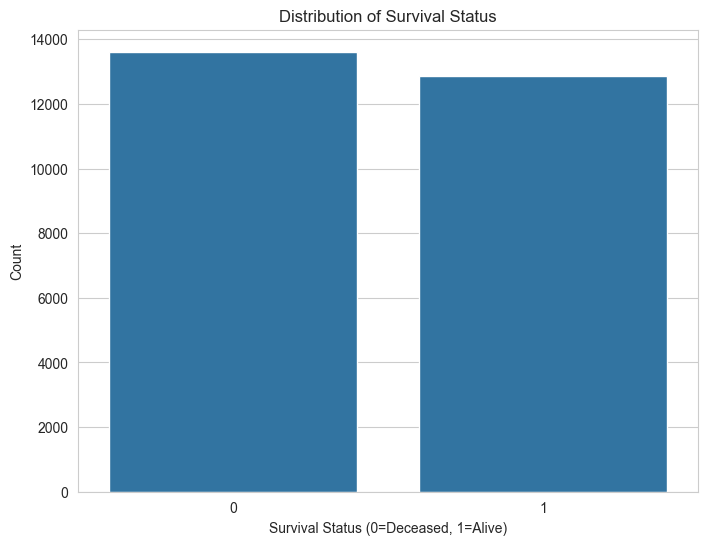

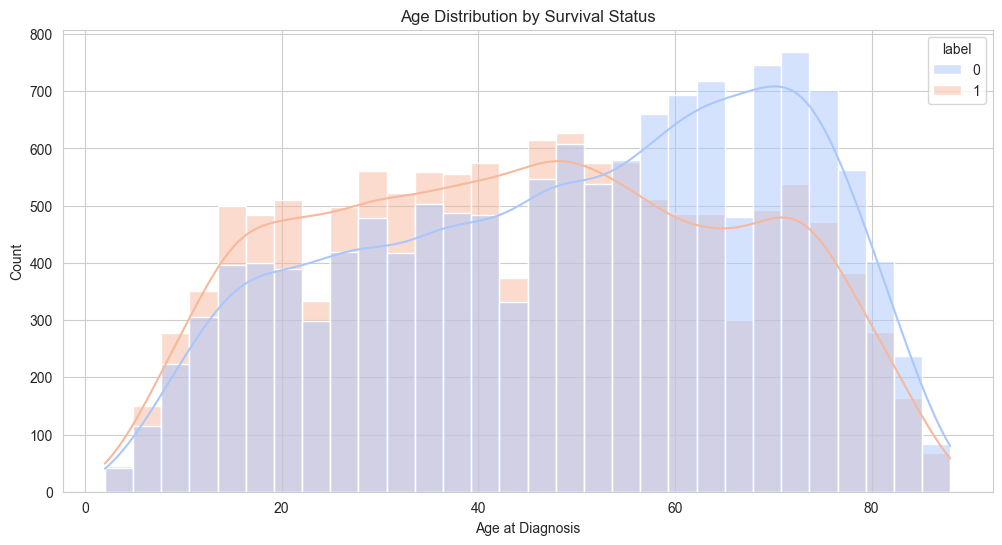

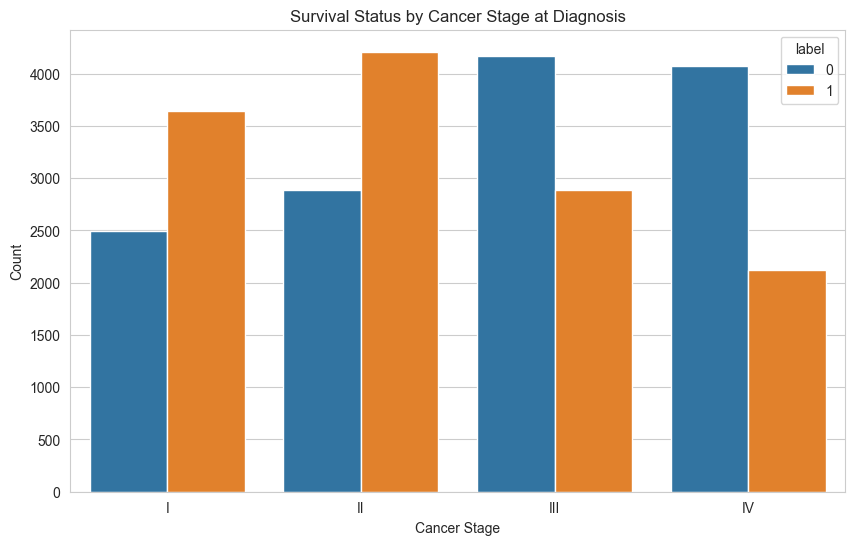

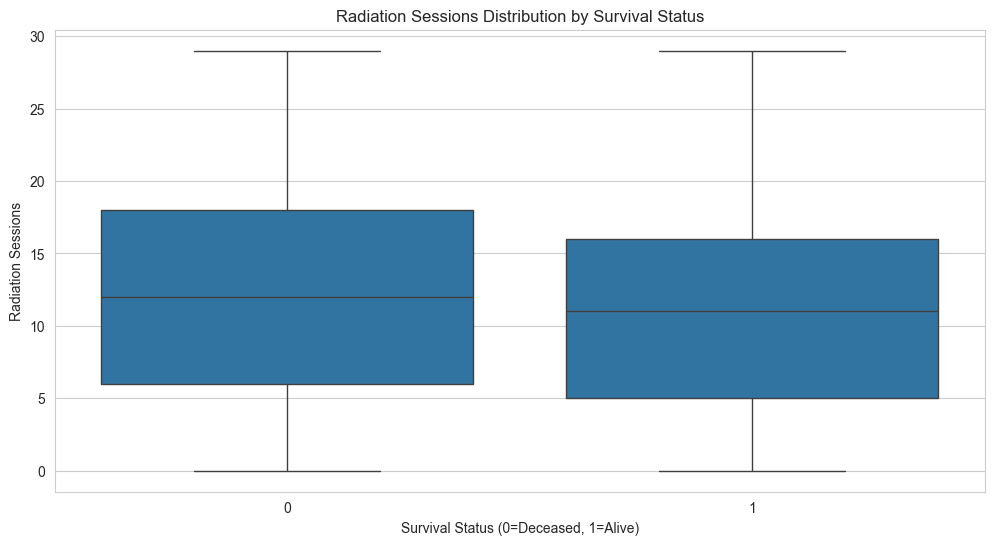

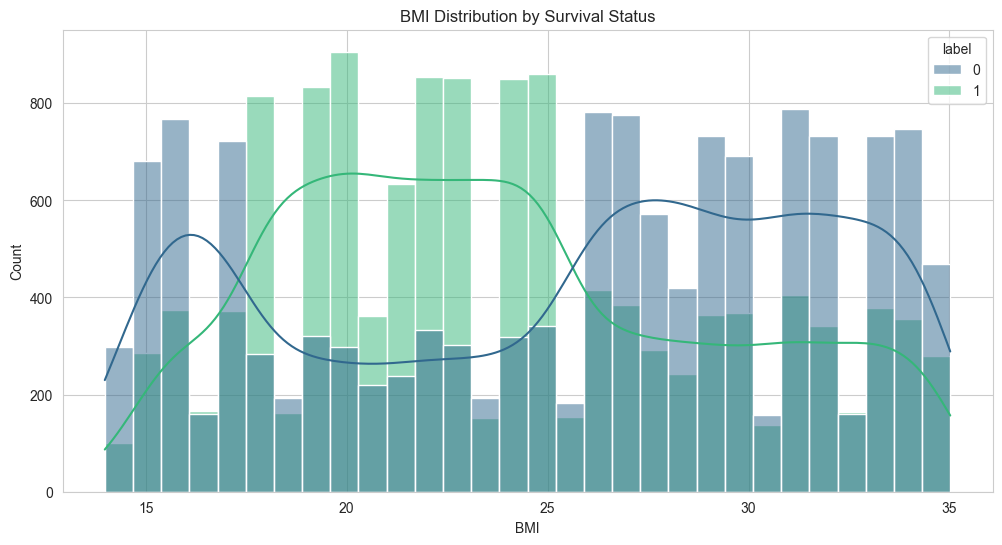

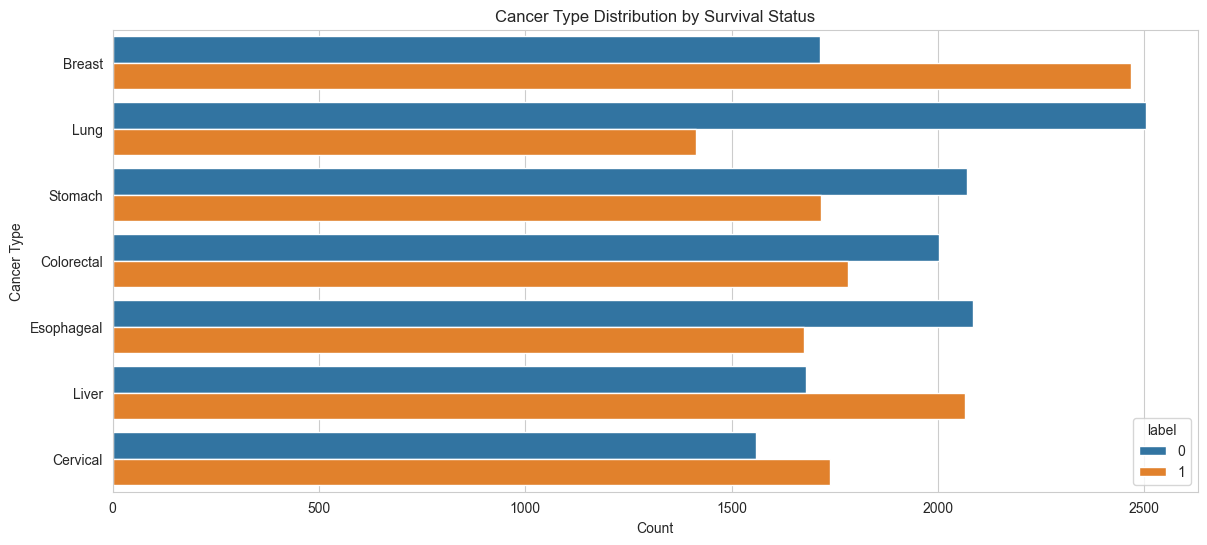

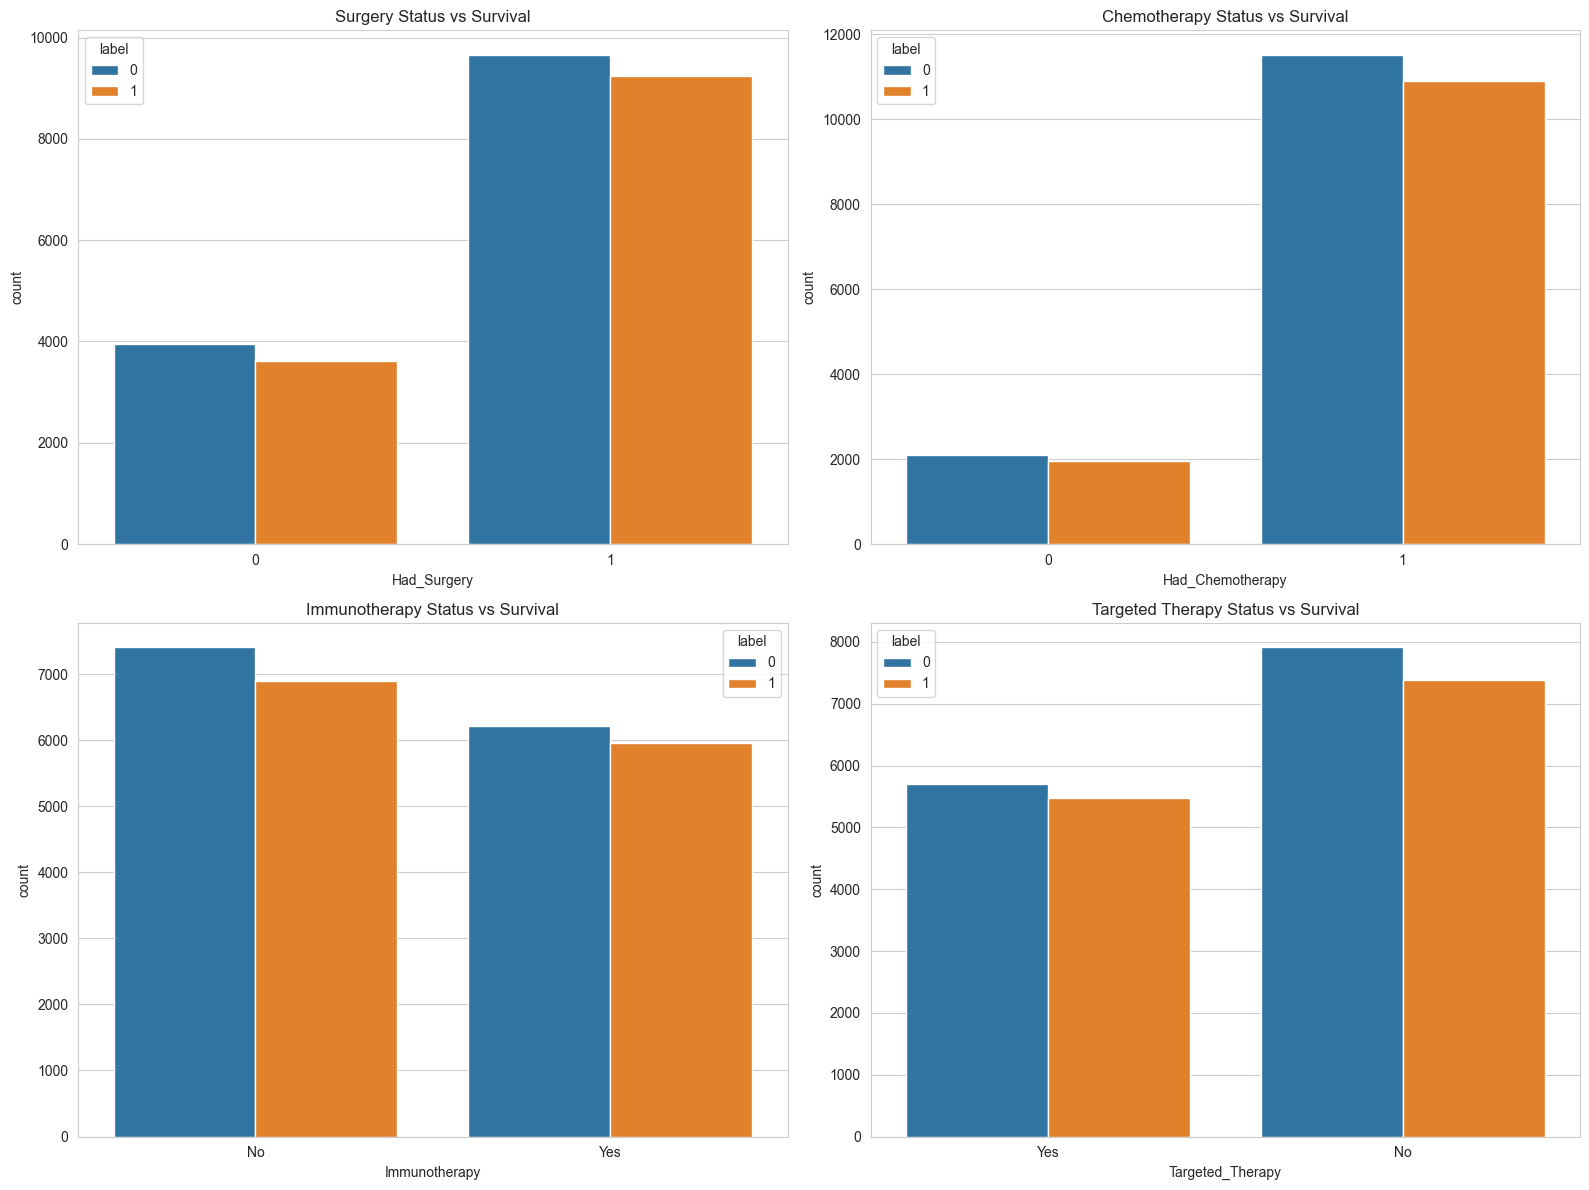

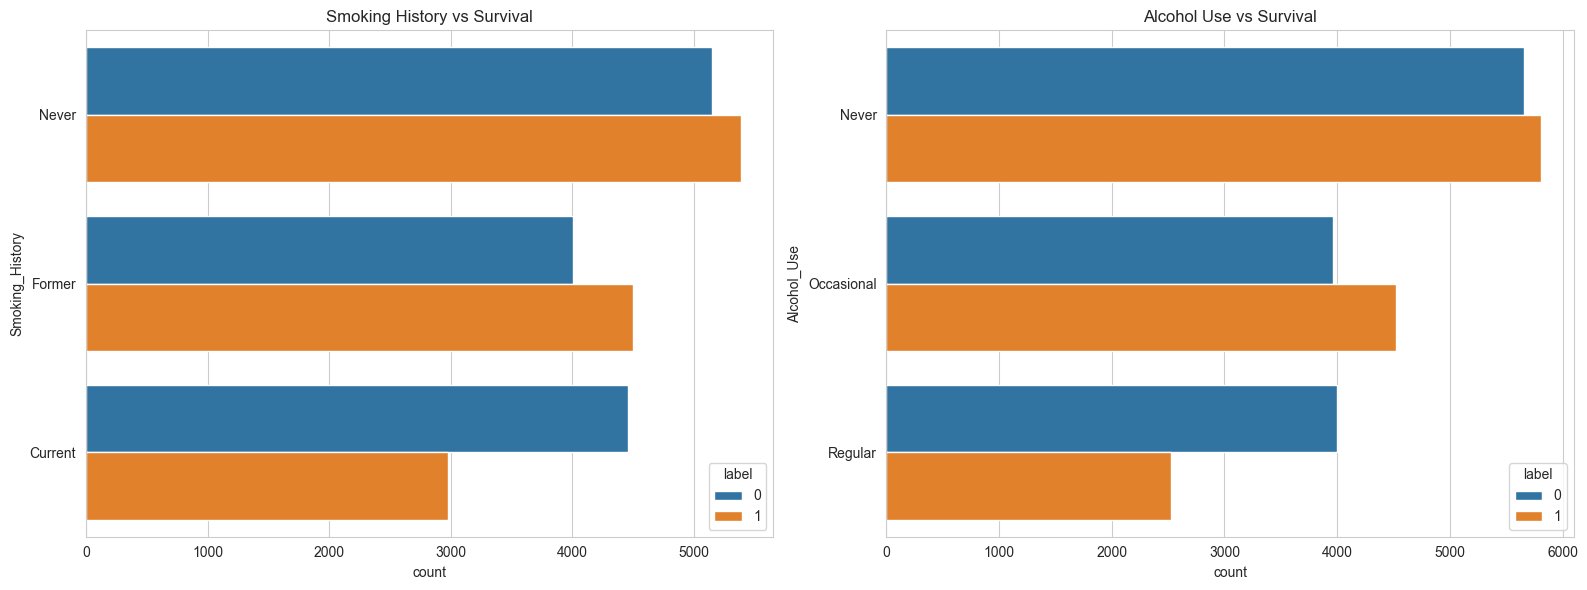

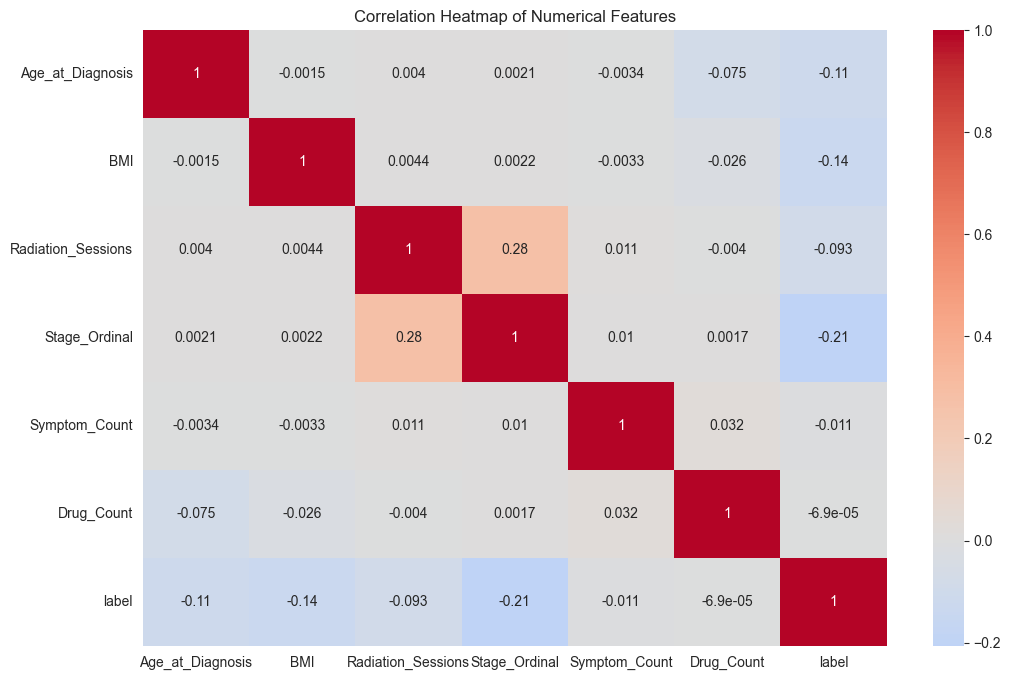

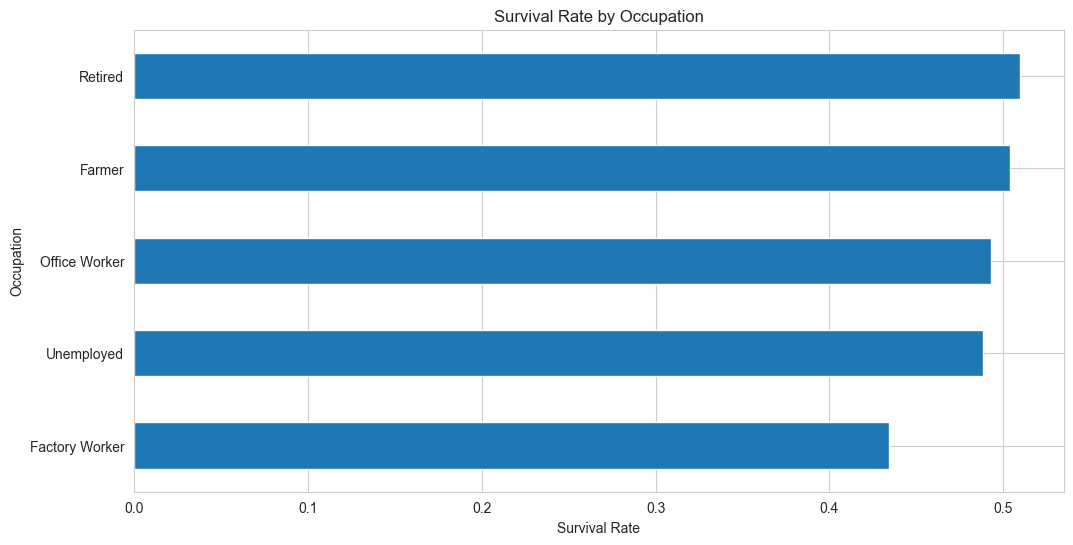

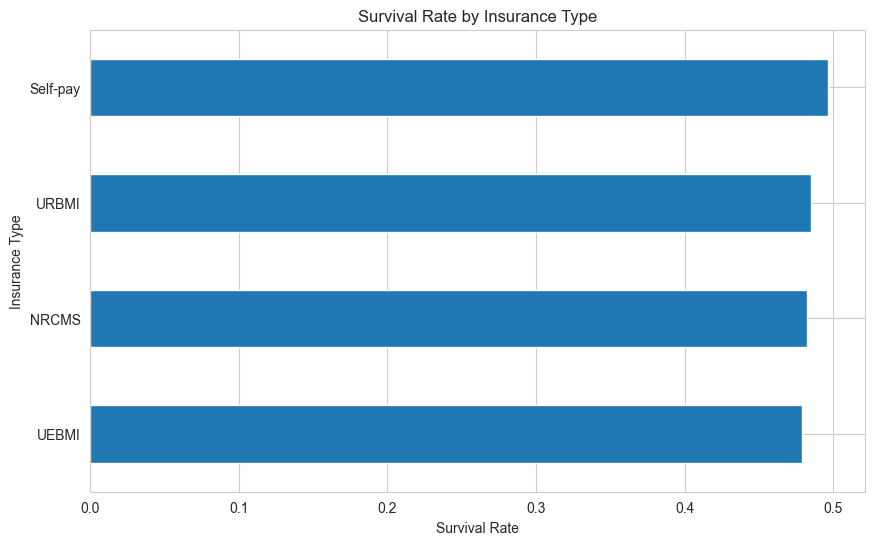

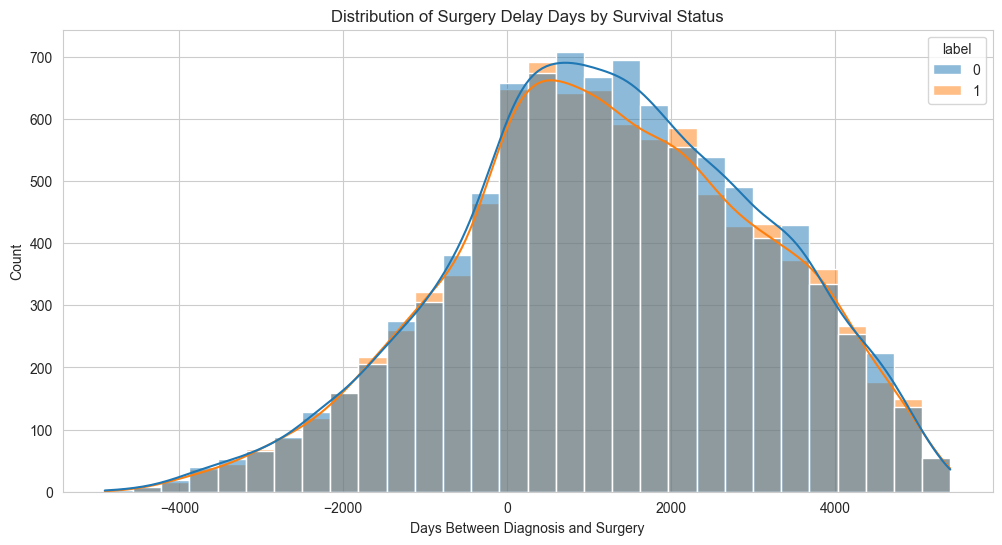

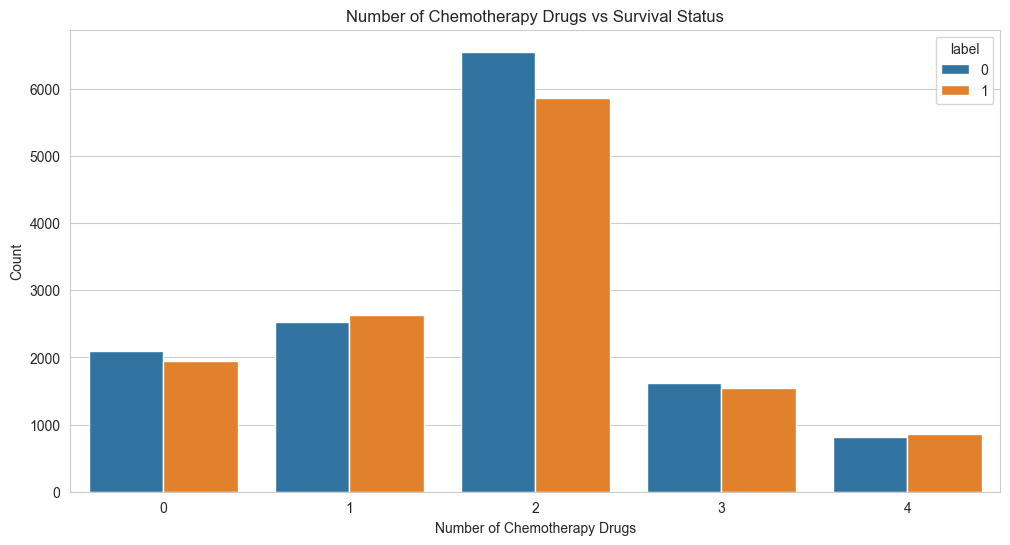

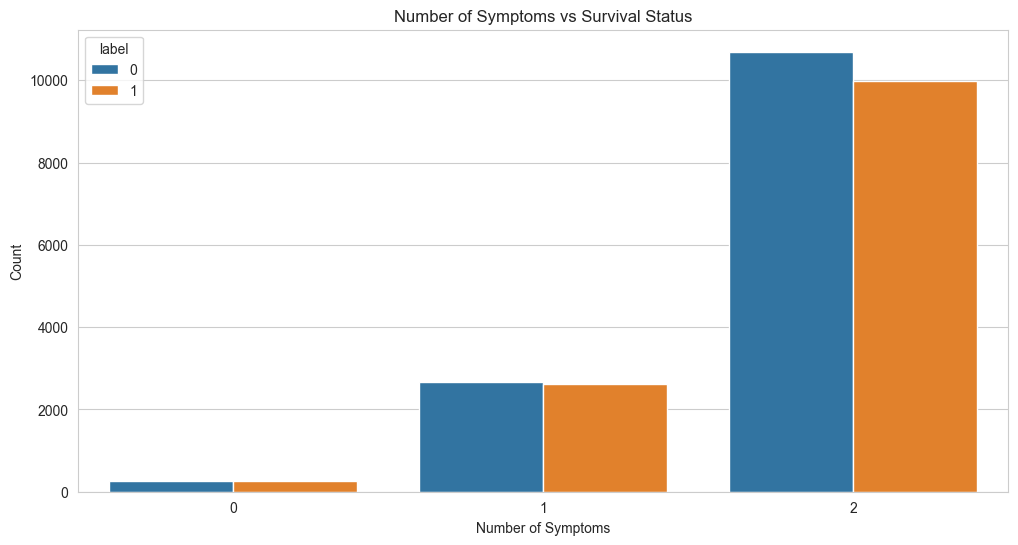

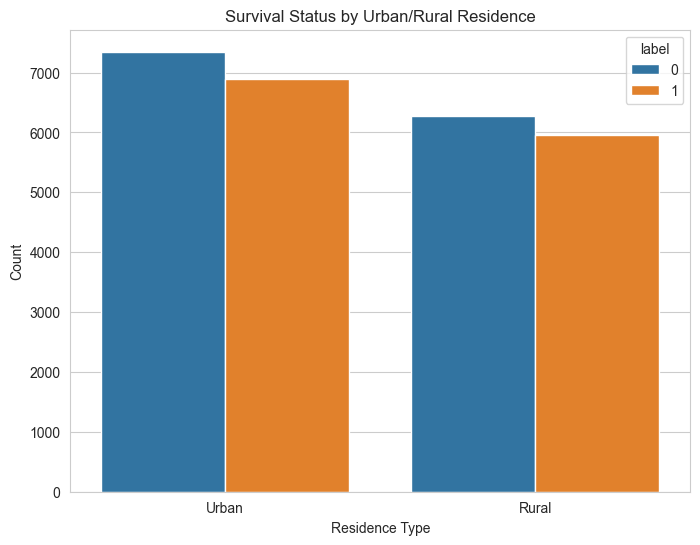

In [36]:
### 1. Target Distribution
plt.figure(figsize=(8, 6))
sns.countplot(x='label', data=df)
plt.title('Distribution of Survival Status')
plt.xlabel('Survival Status (0=Deceased, 1=Alive)')
plt.ylabel('Count')
plt.show()

### 2. Age Distribution by Survival Status
plt.figure(figsize=(12, 6))
sns.histplot(data=df, x='Age_at_Diagnosis', hue='label', kde=True, bins=30, palette='coolwarm')
plt.title('Age Distribution by Survival Status')
plt.xlabel('Age at Diagnosis')
plt.ylabel('Count')
plt.show()

### 3. Cancer Stage vs Survival
plt.figure(figsize=(10, 6))
sns.countplot(x='Stage_at_Diagnosis', hue='label', data=df, order=['I', 'II', 'III', 'IV'])
plt.title('Survival Status by Cancer Stage at Diagnosis')
plt.xlabel('Cancer Stage')
plt.ylabel('Count')
plt.show()

### 4. Radiation Sessions vs Survival
plt.figure(figsize=(12, 6))
sns.boxplot(x='label', y='Radiation_Sessions', data=df)
plt.title('Radiation Sessions Distribution by Survival Status')
plt.xlabel('Survival Status (0=Deceased, 1=Alive)')
plt.ylabel('Radiation Sessions')
plt.show()

### 5. BMI Distribution by Survival
plt.figure(figsize=(12, 6))
sns.histplot(data=df, x='BMI', hue='label', kde=True, bins=30, palette='viridis')
plt.title('BMI Distribution by Survival Status')
plt.xlabel('BMI')
plt.ylabel('Count')
plt.show()

### 6. Cancer Type Distribution by Survival
plt.figure(figsize=(14, 6))
sns.countplot(y='Cancer_Type', hue='label', data=df, order=df['Cancer_Type'].value_counts().index)
plt.title('Cancer Type Distribution by Survival Status')
plt.ylabel('Cancer Type')
plt.xlabel('Count')
plt.show()

### 7. Treatment Modalities vs Survival
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

sns.countplot(x='Had_Surgery', hue='label', data=df, ax=axes[0, 0])
axes[0, 0].set_title('Surgery Status vs Survival')

sns.countplot(x='Had_Chemotherapy', hue='label', data=df, ax=axes[0, 1])
axes[0, 1].set_title('Chemotherapy Status vs Survival')

sns.countplot(x='Immunotherapy', hue='label', data=df, ax=axes[1, 0])
axes[1, 0].set_title('Immunotherapy Status vs Survival')

sns.countplot(x='Targeted_Therapy', hue='label', data=df, ax=axes[1, 1])
axes[1, 1].set_title('Targeted Therapy Status vs Survival')

plt.tight_layout()
plt.show()

### 8. Lifestyle Factors
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

sns.countplot(y='Smoking_History', hue='label', data=df, ax=axes[0], order=['Never', 'Former', 'Current'])
axes[0].set_title('Smoking History vs Survival')

sns.countplot(y='Alcohol_Use', hue='label', data=df, ax=axes[1], order=['Never', 'Occasional', 'Regular'])
axes[1].set_title('Alcohol Use vs Survival')

plt.tight_layout()
plt.show()

### 9. Correlation Heatmap (for numerical features)
numerical_features = ['Age_at_Diagnosis', 'BMI', 'Radiation_Sessions', 'Stage_Ordinal', 
                     'Symptom_Count', 'Drug_Count', 'label']
plt.figure(figsize=(12, 8))
corr_matrix = df[numerical_features].corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('Correlation Heatmap of Numerical Features')
plt.show()

### 10. Survival Rate by Occupation
occupation_survival = df.groupby('Occupation')['label'].mean().sort_values()
plt.figure(figsize=(12, 6))
occupation_survival.plot(kind='barh')
plt.title('Survival Rate by Occupation')
plt.xlabel('Survival Rate')
plt.ylabel('Occupation')
plt.show()

### 11. Survival Rate by Insurance Type
insurance_survival = df.groupby('Insurance_Type')['label'].mean().sort_values()
plt.figure(figsize=(10, 6))
insurance_survival.plot(kind='barh')
plt.title('Survival Rate by Insurance Type')
plt.xlabel('Survival Rate')
plt.ylabel('Insurance Type')
plt.show()

### 12. Time Between Diagnosis and Surgery (for patients who had surgery)
if df['Had_Surgery'].sum() > 0:
    plt.figure(figsize=(12, 6))
    sns.histplot(data=df[df['Had_Surgery']==1], x='Surgery_Delay', hue='label', kde=True, bins=30)
    plt.title('Distribution of Surgery Delay Days by Survival Status')
    plt.xlabel('Days Between Diagnosis and Surgery')
    plt.ylabel('Count')
    plt.show()

### 13. Drug Count vs Survival
plt.figure(figsize=(12, 6))
sns.countplot(x='Drug_Count', hue='label', data=df)
plt.title('Number of Chemotherapy Drugs vs Survival Status')
plt.xlabel('Number of Chemotherapy Drugs')
plt.ylabel('Count')
plt.show()

### 14. Symptom Count vs Survival
plt.figure(figsize=(12, 6))
sns.countplot(x='Symptom_Count', hue='label', data=df)
plt.title('Number of Symptoms vs Survival Status')
plt.xlabel('Number of Symptoms')
plt.ylabel('Count')
plt.show()

### 15. Urban/Rural vs Survival
plt.figure(figsize=(8, 6))
sns.countplot(x='Urban_Rural', hue='label', data=df)
plt.title('Survival Status by Urban/Rural Residence')
plt.xlabel('Residence Type')
plt.ylabel('Count')
plt.show()

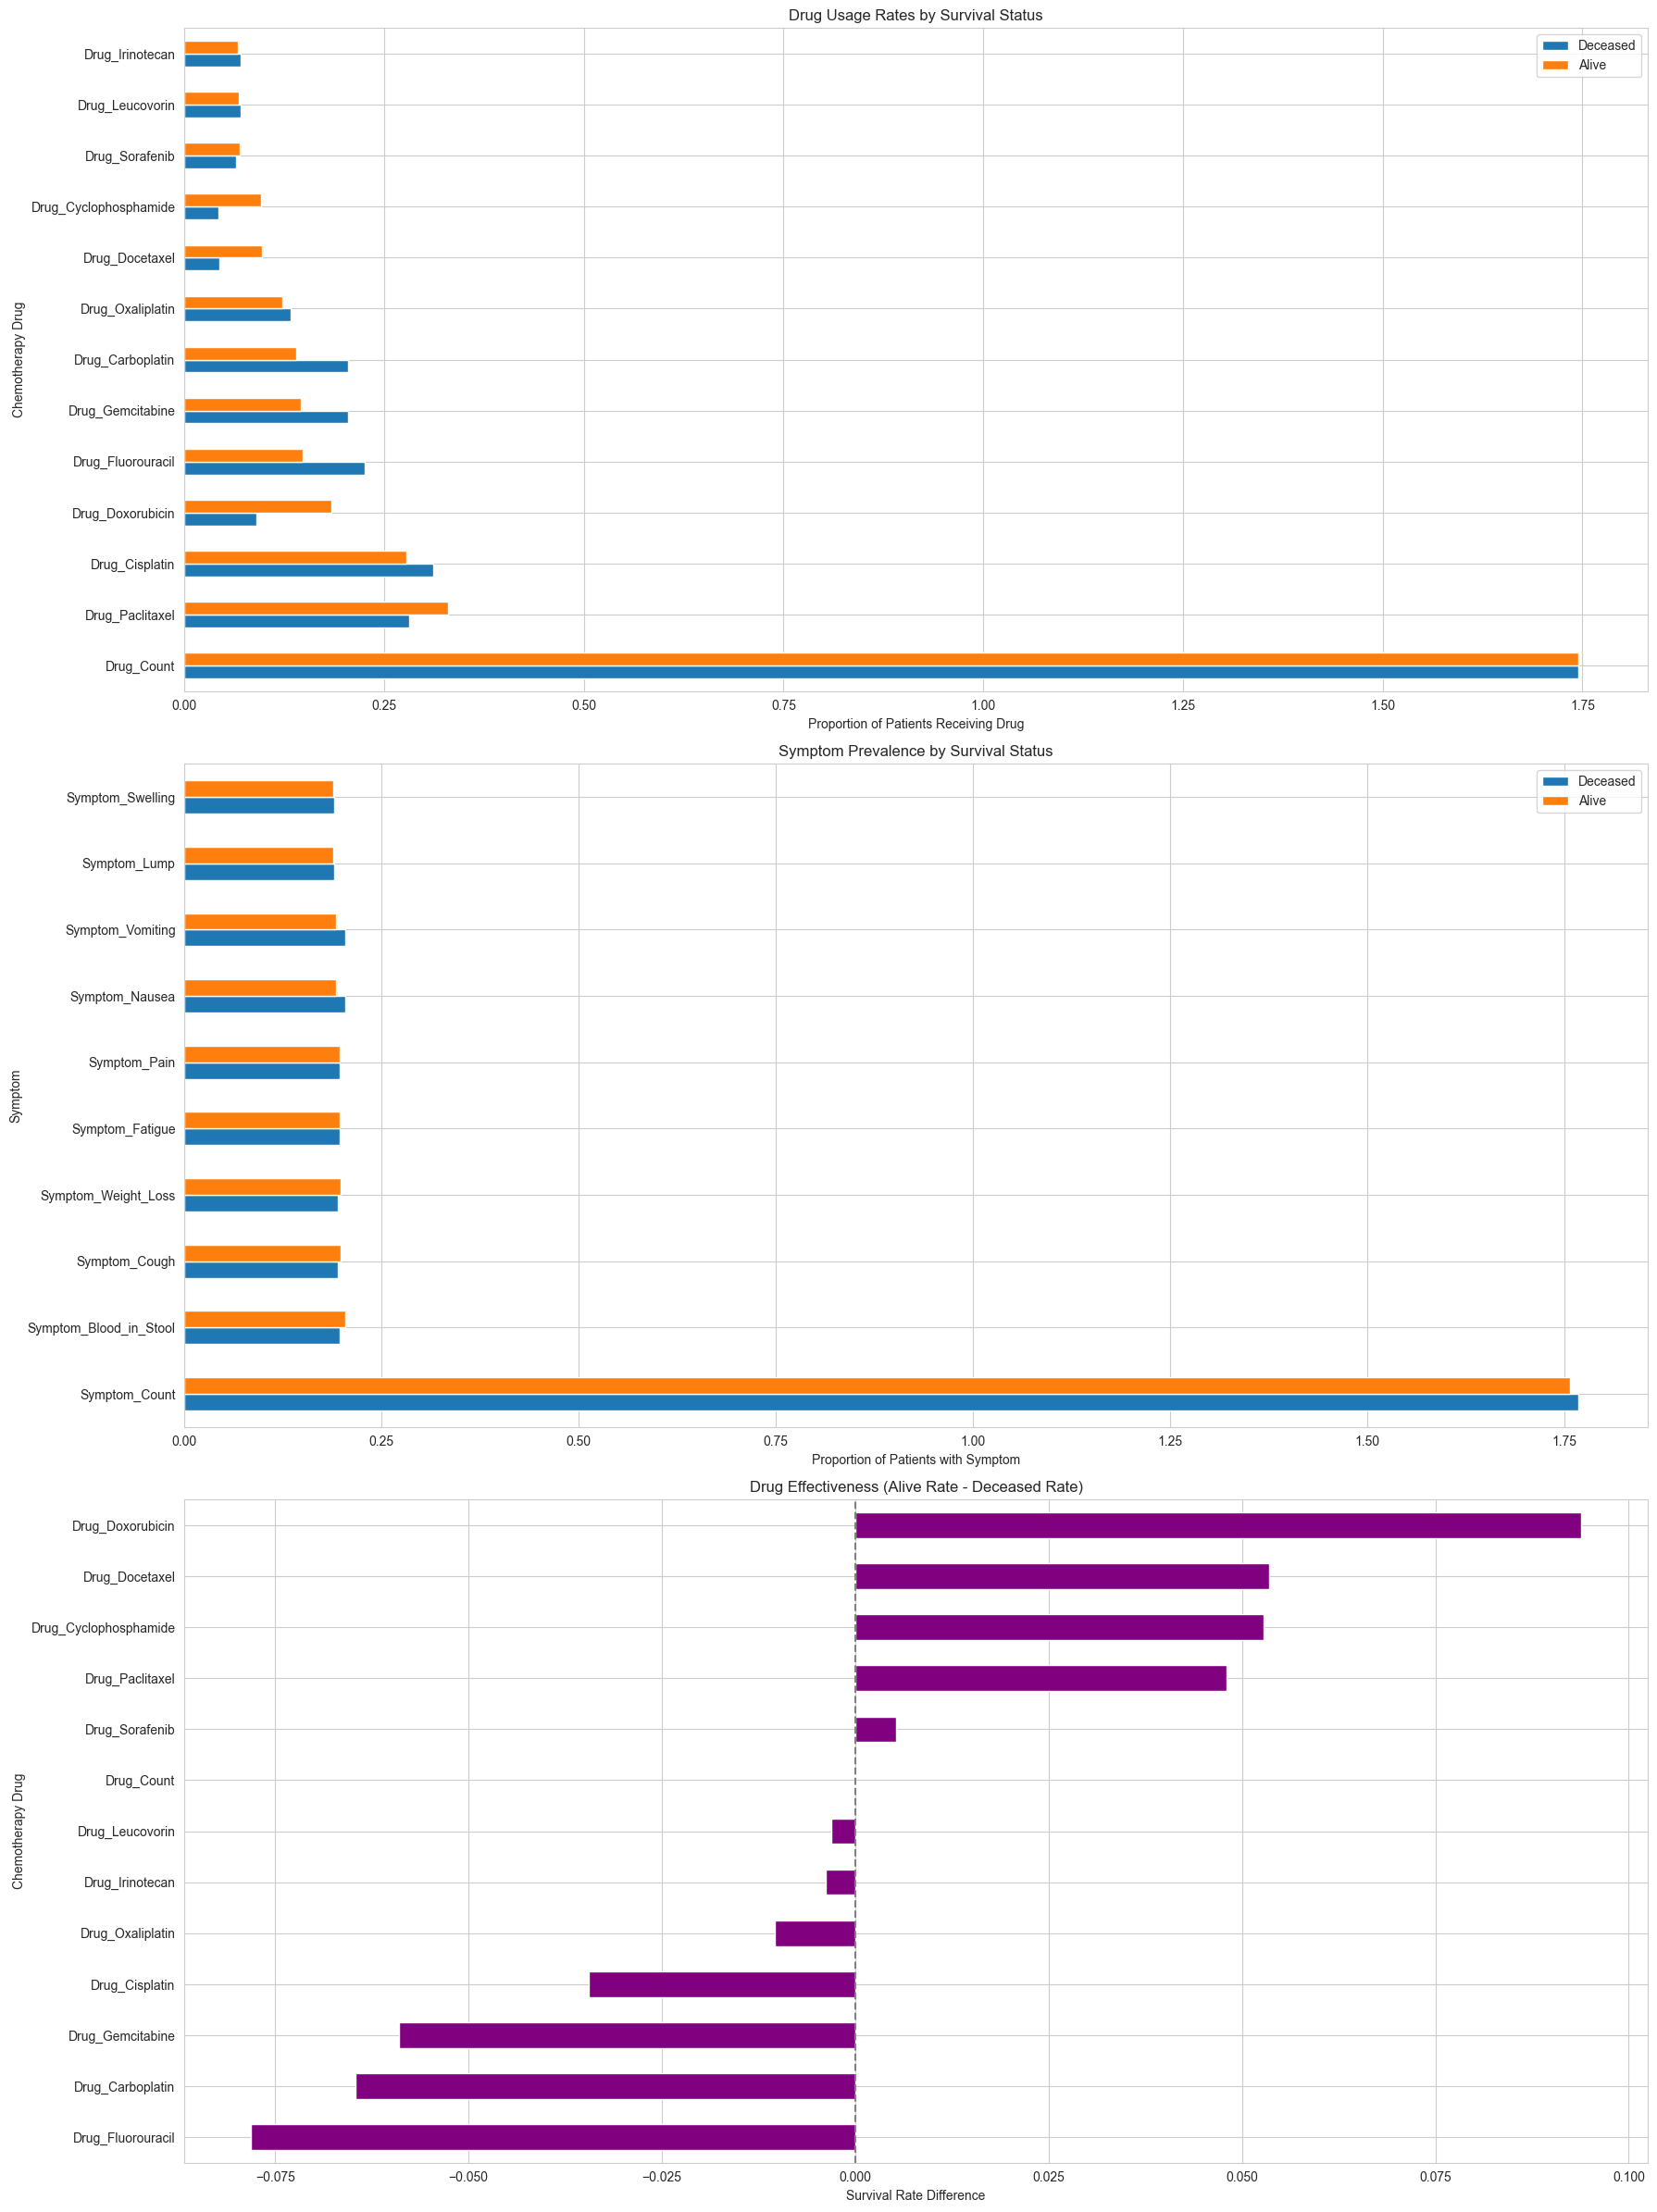

In [37]:
# Set up the figure
plt.figure(figsize=(18, 24))

# Get the top N drugs/symptoms to visualize (avoid overcrowding)
top_drugs = sorted([col for col in df.columns if col.startswith('Drug_')], 
                   key=lambda x: df[x].sum(), reverse=True)[:15]
top_symptoms = sorted([col for col in df.columns if col.startswith('Symptom_')], 
                     key=lambda x: df[x].sum(), reverse=True)[:15]

# Plot drug survival rates
plt.subplot(3, 1, 1)
drug_survival = df.groupby('label')[top_drugs].mean().T.sort_values(1, ascending=False)
drug_survival.plot(kind='barh', stacked=False, ax=plt.gca())
plt.title('Drug Usage Rates by Survival Status')
plt.xlabel('Proportion of Patients Receiving Drug')
plt.ylabel('Chemotherapy Drug')
plt.legend(['Deceased', 'Alive'])

# Plot symptom survival rates
plt.subplot(3, 1, 2)
symptom_survival = df.groupby('label')[top_symptoms].mean().T.sort_values(1, ascending=False)
symptom_survival.plot(kind='barh', stacked=False, ax=plt.gca())
plt.title('Symptom Prevalence by Survival Status')
plt.xlabel('Proportion of Patients with Symptom')
plt.ylabel('Symptom')
plt.legend(['Deceased', 'Alive'])

# Plot drug effectiveness (difference between survival groups)
plt.subplot(3, 1, 3)
drug_effect = drug_survival[1] - drug_survival[0]
drug_effect.sort_values().plot(kind='barh', color='purple')
plt.title('Drug Effectiveness (Alive Rate - Deceased Rate)')
plt.xlabel('Survival Rate Difference')
plt.ylabel('Chemotherapy Drug')
plt.axvline(0, color='gray', linestyle='--')

plt.tight_layout()
plt.show()

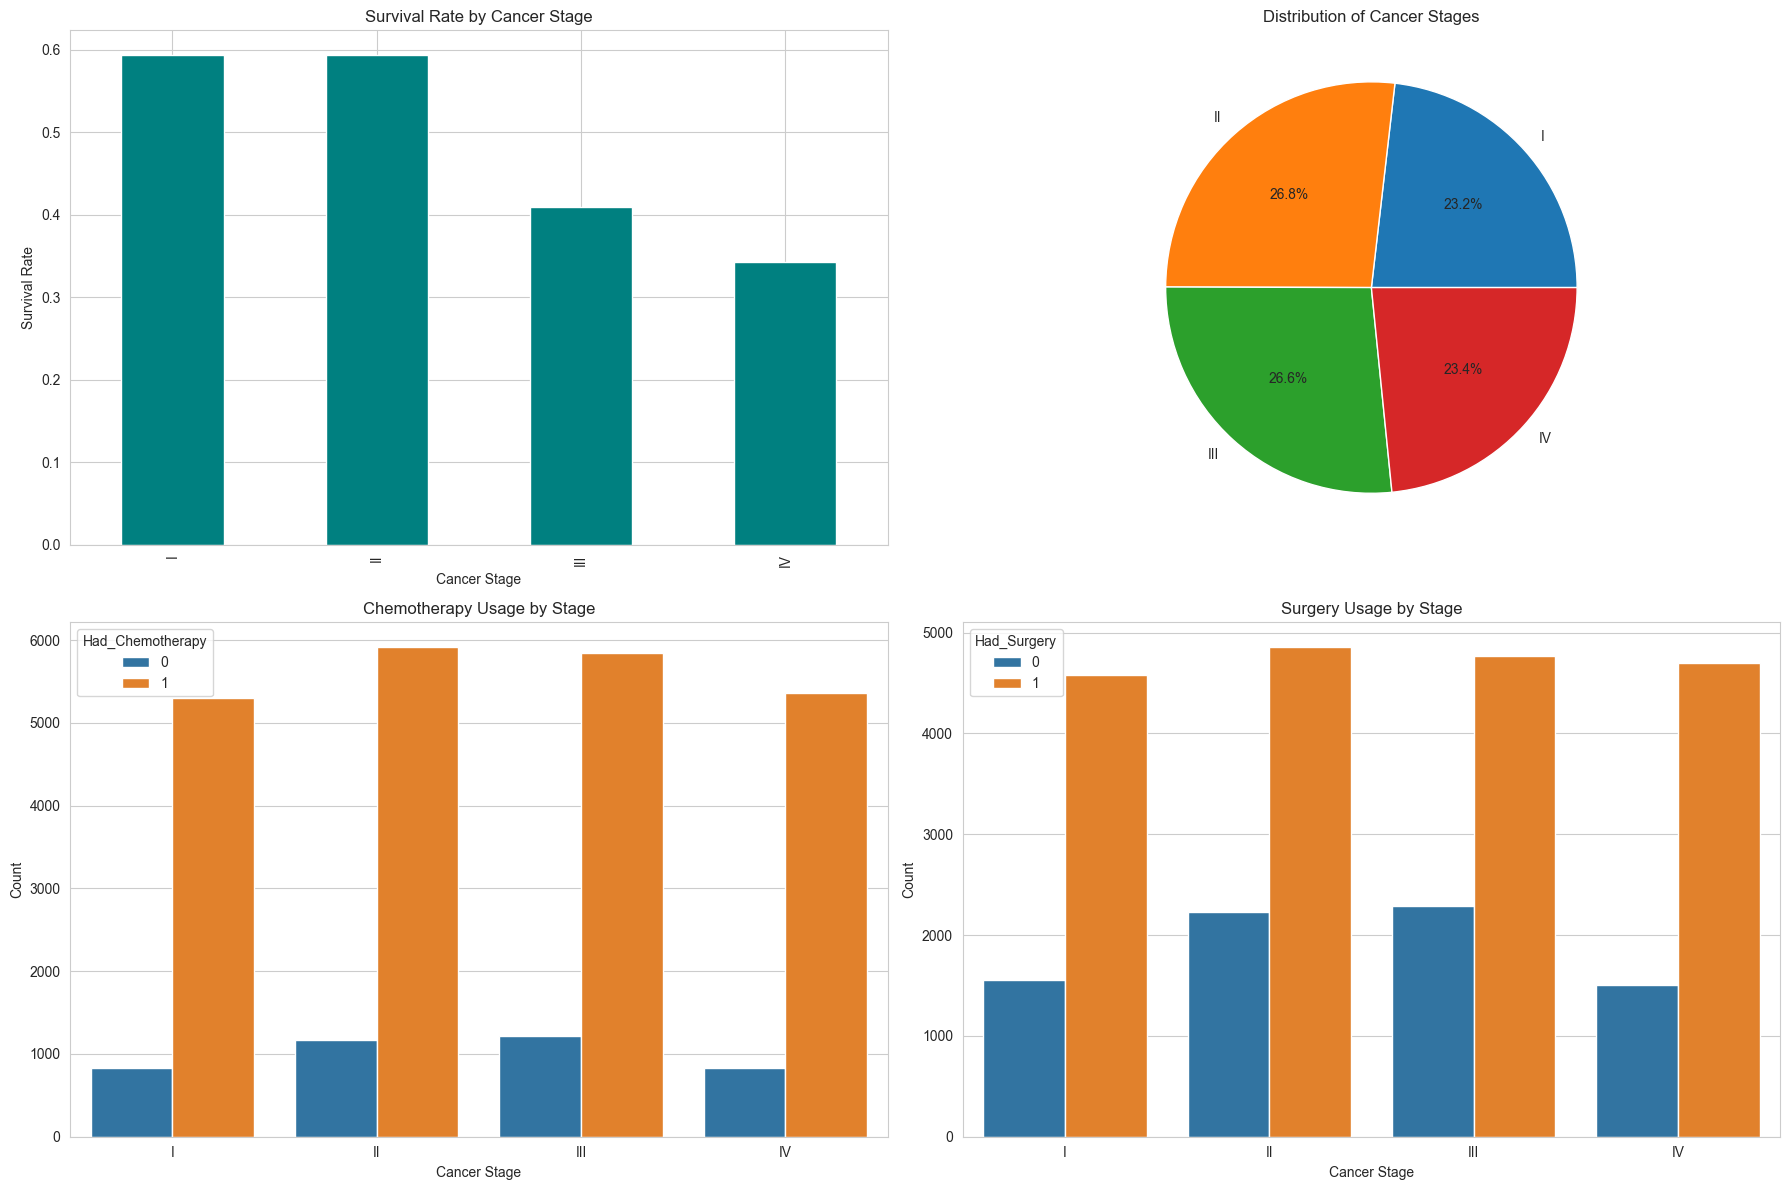

In [38]:
plt.figure(figsize=(18, 12))

# Survival rate by stage
plt.subplot(2, 2, 1)
stage_survival = df.groupby('Stage_at_Diagnosis')['label'].mean().reindex(['I', 'II', 'III', 'IV'])
stage_survival.plot(kind='bar', color='teal')
plt.title('Survival Rate by Cancer Stage')
plt.ylabel('Survival Rate')
plt.xlabel('Cancer Stage')

# Stage distribution
plt.subplot(2, 2, 2)
df['Stage_at_Diagnosis'].value_counts().reindex(['I', 'II', 'III', 'IV']).plot(kind='pie', autopct='%1.1f%%')
plt.title('Distribution of Cancer Stages')
plt.ylabel('')

# Treatment modalities by stage
plt.subplot(2, 2, 3)
sns.countplot(x='Stage_at_Diagnosis', hue='Had_Chemotherapy', data=df, order=['I', 'II', 'III', 'IV'])
plt.title('Chemotherapy Usage by Stage')
plt.xlabel('Cancer Stage')
plt.ylabel('Count')

plt.subplot(2, 2, 4)
sns.countplot(x='Stage_at_Diagnosis', hue='Had_Surgery', data=df, order=['I', 'II', 'III', 'IV'])
plt.title('Surgery Usage by Stage')
plt.xlabel('Cancer Stage')
plt.ylabel('Count')

plt.tight_layout()
plt.show()

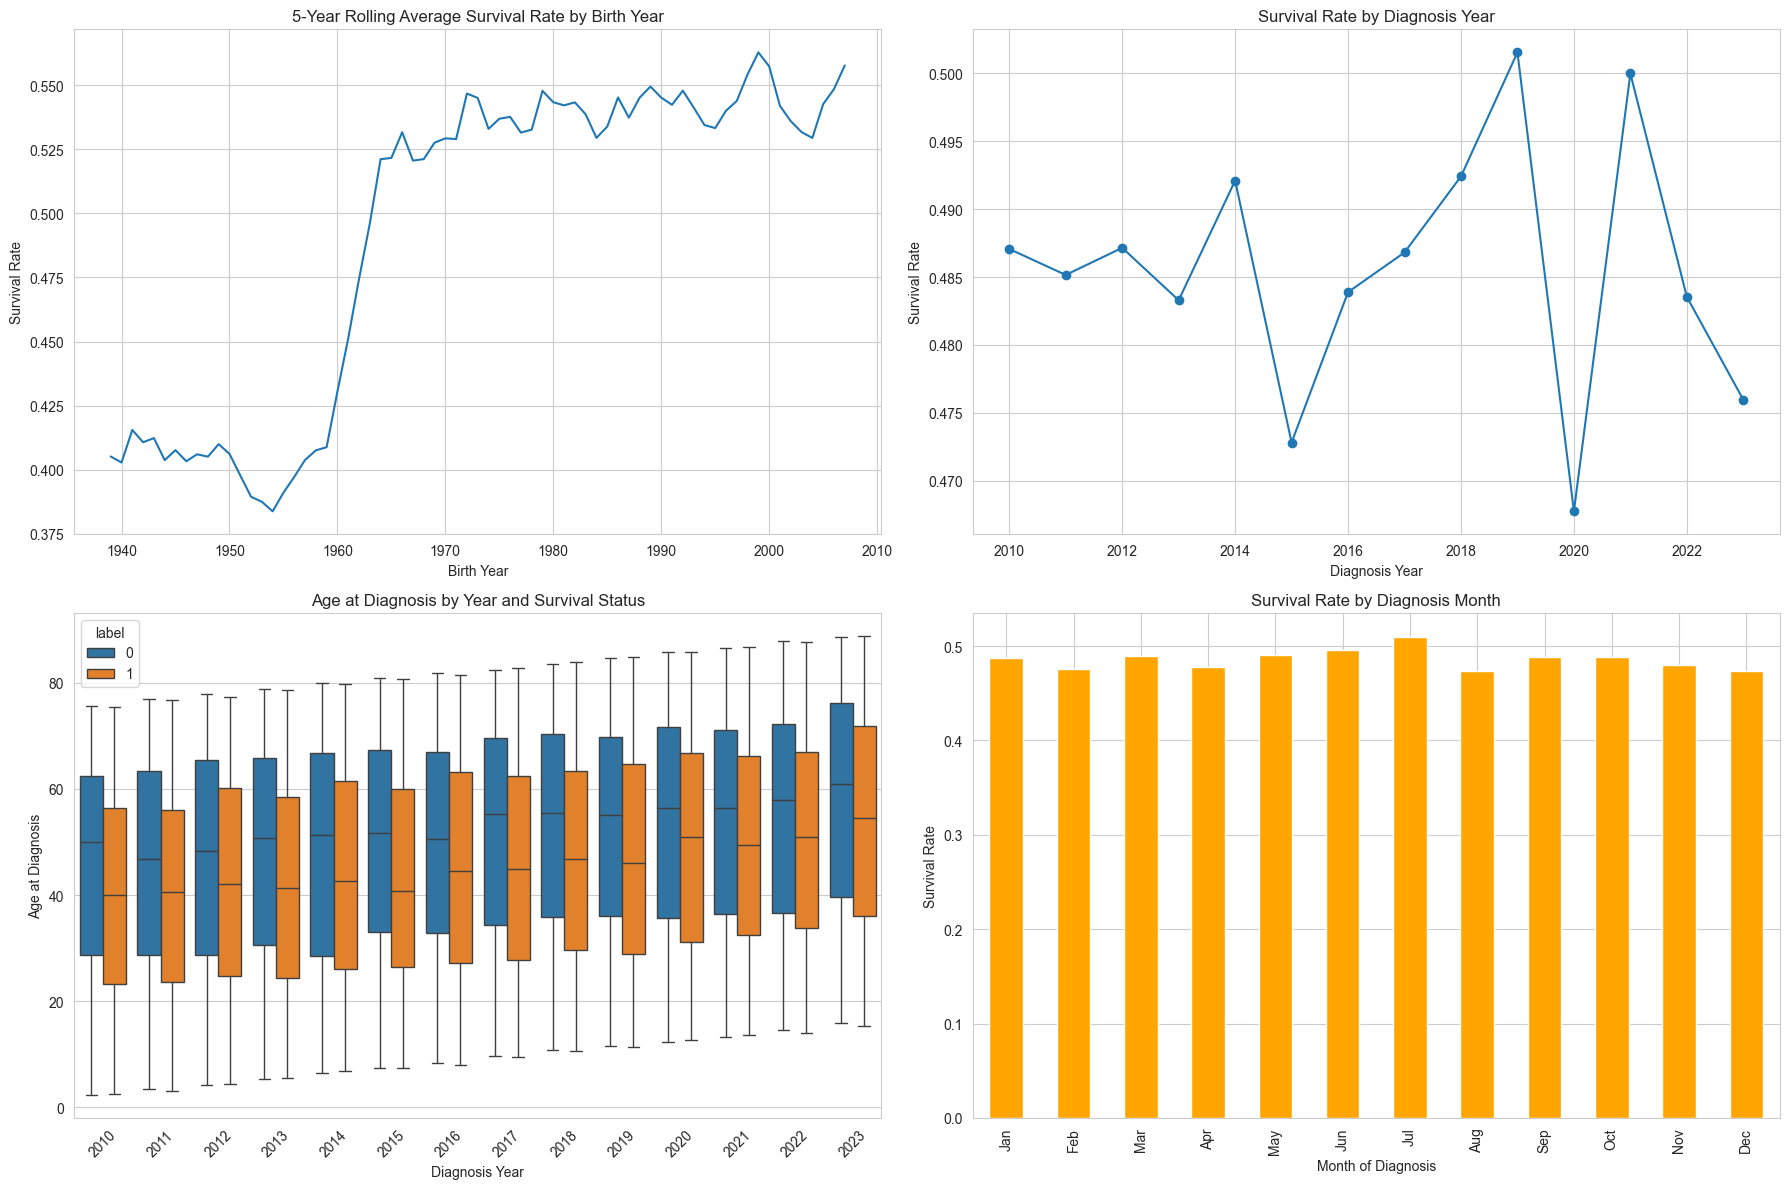

In [39]:
plt.figure(figsize=(18, 12))

# Convert dates to datetime if not already
df['Birth_Date'] = pd.to_datetime(df['Birth_Date'])
df['Diagnosis_Date'] = pd.to_datetime(df['Diagnosis_Date'])

# Birth year analysis
plt.subplot(2, 2, 1)
df['Birth_Year'] = df['Birth_Date'].dt.year
birth_year_survival = df.groupby('Birth_Year')['label'].mean()
birth_year_survival.rolling(5).mean().plot()
plt.title('5-Year Rolling Average Survival Rate by Birth Year')
plt.ylabel('Survival Rate')
plt.xlabel('Birth Year')

# Diagnosis year analysis
plt.subplot(2, 2, 2)
df['Diagnosis_Year'] = df['Diagnosis_Date'].dt.year
diagnosis_year_survival = df.groupby('Diagnosis_Year')['label'].mean()
diagnosis_year_survival.plot(marker='o')
plt.title('Survival Rate by Diagnosis Year')
plt.ylabel('Survival Rate')
plt.xlabel('Diagnosis Year')

# Age at diagnosis trends
plt.subplot(2, 2, 3)
df['Age_at_Diagnosis'] = (df['Diagnosis_Date'] - df['Birth_Date']).dt.days / 365.25
sns.boxplot(x='Diagnosis_Year', y='Age_at_Diagnosis', hue='label', data=df)
plt.title('Age at Diagnosis by Year and Survival Status')
plt.ylabel('Age at Diagnosis')
plt.xlabel('Diagnosis Year')
plt.xticks(rotation=45)

# Monthly diagnosis patterns
plt.subplot(2, 2, 4)
df['Diagnosis_Month'] = df['Diagnosis_Date'].dt.month
monthly_survival = df.groupby('Diagnosis_Month')['label'].mean()
monthly_survival.plot(kind='bar', color='orange')
plt.title('Survival Rate by Diagnosis Month')
plt.ylabel('Survival Rate')
plt.xlabel('Month of Diagnosis')
plt.xticks(range(12), ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 
                      'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])

plt.tight_layout()
plt.show()

<Figure size 1000x600 with 0 Axes>

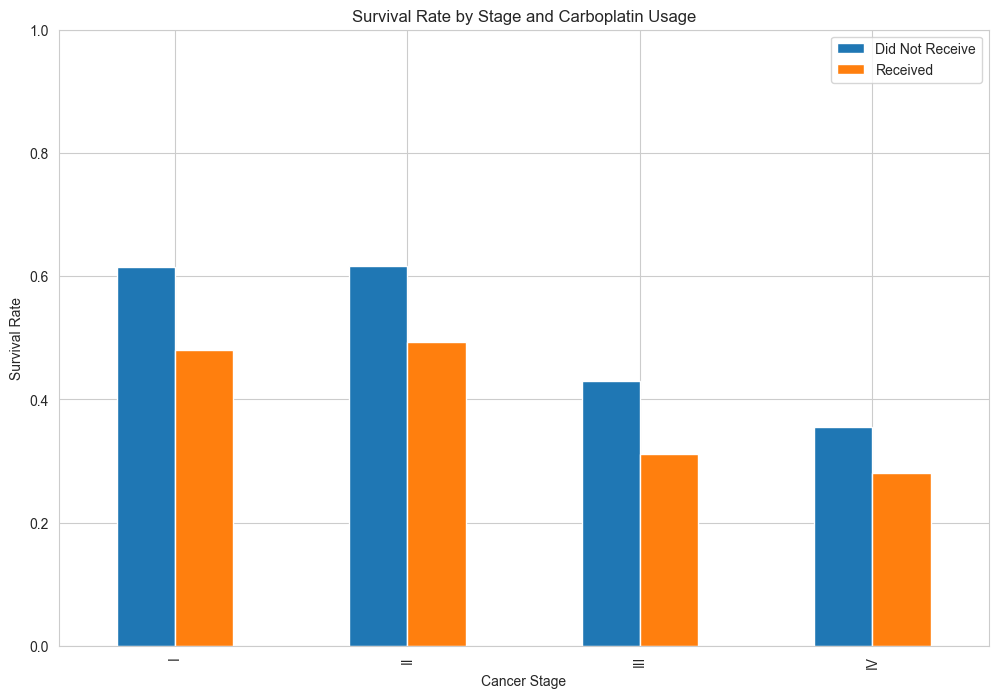

<Figure size 1000x600 with 0 Axes>

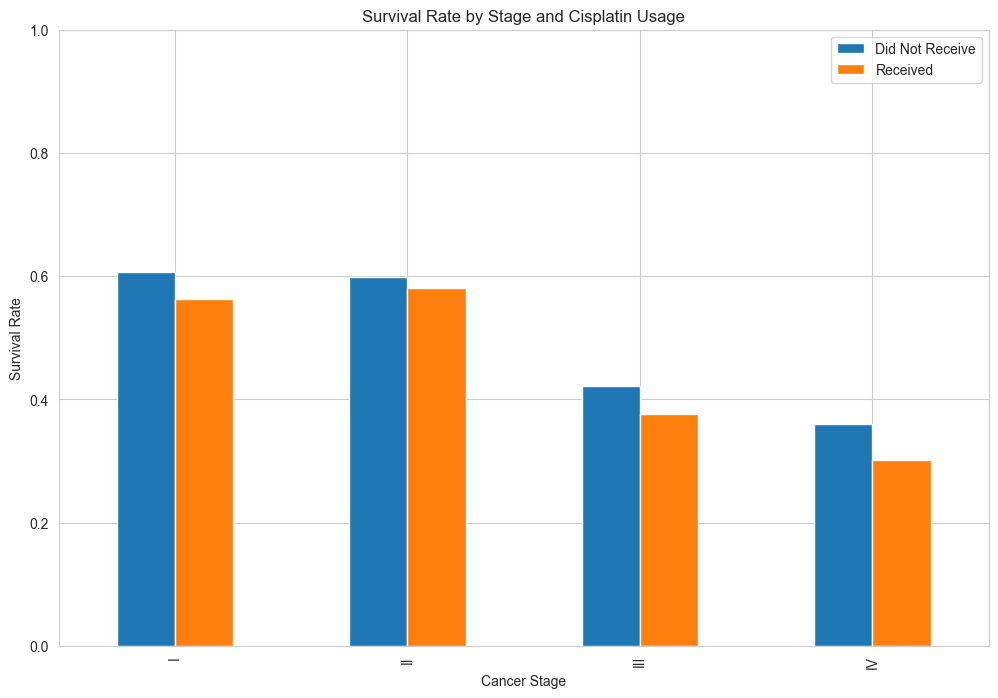

<Figure size 1000x600 with 0 Axes>

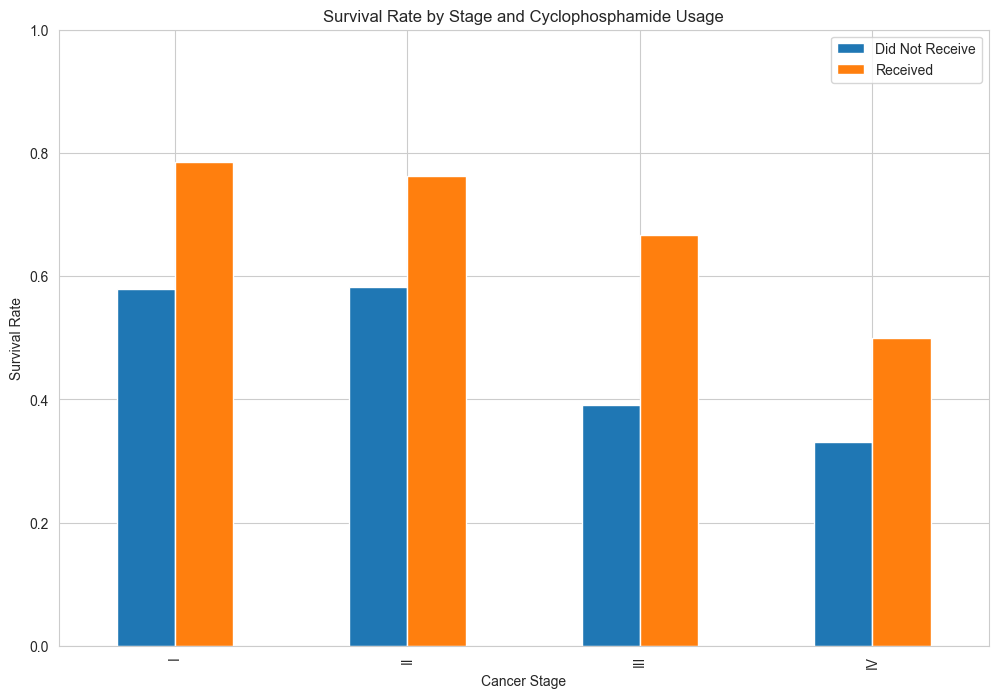

In [40]:
# Create a pivot table for drug effectiveness by stage
top_3_drugs = [col for col in df.columns if col.startswith('Drug_')][1:4]
for drug in top_3_drugs:
    plt.figure(figsize=(10, 6))
    pivot = pd.pivot_table(df, values='label', index='Stage_at_Diagnosis', 
                          columns=drug, aggfunc='mean')
    pivot.plot(kind='bar')
    plt.title(f'Survival Rate by Stage and {drug.replace("Drug_", "")} Usage')
    plt.ylabel('Survival Rate')
    plt.xlabel('Cancer Stage')
    plt.legend(['Did Not Receive', 'Received'])
    plt.ylim(0, 1)
    plt.show()

In [18]:
# Check for duplicate column names
duplicate_columns = df.columns[df.columns.duplicated()]
print("Duplicate columns:", duplicate_columns)

Duplicate columns: Index([], dtype='object')


In [44]:
# Get all drug and symptom columns
all_drug_columns = [col for col in df.columns if col.startswith('Drug_') and col != 'Drug_Count']
all_symptom_columns = [col for col in df.columns if col.startswith('Symptom_')]

# Define feature columns
useful_features = [
    # Demographic
    'Age_at_Diagnosis', 'BMI', 'Urban_Rural', 'Insurance_Type', 
    
    # Cancer characteristics
    'Cancer_Type', 'Stage_Ordinal', 'Tumor_Size', 'Recurrence_Status',
    
    # Treatment related
    'Had_Surgery', 'Had_Chemotherapy', 'Radiation_Sessions',
    'Immunotherapy', 'Targeted_Therapy', 'Drug_Count',
    
    # All drugs and symptoms
    *all_drug_columns,
    *all_symptom_columns,
    
    # Lifestyle
    'Smoking_History', 'Alcohol_Use',
    
    # Temporal
    'Diagnosis_Year'
]

df = df.dropna(subset=['Age_at_Diagnosis'])

# Separate features and target
X = df[useful_features]
y = df['label']

# Define categorical and numerical features
categorical_features = [
    'Urban_Rural', 'Insurance_Type', 'Cancer_Type', 
    'Recurrence_Status', 'Immunotherapy', 'Targeted_Therapy',
    'Smoking_History', 'Alcohol_Use'
]

numerical_features = [
    'Age_at_Diagnosis', 'BMI', 'Stage_Ordinal', 'Tumor_Size',
    'Radiation_Sessions', 'Drug_Count',
    'Diagnosis_Year'
]

# Binary features (drugs and symptoms)
binary_features = all_drug_columns + all_symptom_columns
binary_features = [col for col in binary_features 
                  if not col == 'Drug_Count' and 
                  (col.startswith('Drug_') or col.startswith('Symptom_'))]

# Preprocessing pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features),
        ('binary', 'passthrough', binary_features)
    ],
    verbose_feature_names_out=False  # This prevents the prefixes
)
# Split into train and validation sets (80-20)
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y)


In [45]:
X.isna().sum()

Age_at_Diagnosis          0
BMI                       0
Urban_Rural               0
Insurance_Type            0
Cancer_Type               0
Stage_Ordinal             0
Tumor_Size                0
Recurrence_Status         0
Had_Surgery               0
Had_Chemotherapy          0
Radiation_Sessions        0
Immunotherapy             0
Targeted_Therapy          0
Drug_Count                0
Drug_Carboplatin          0
Drug_Cisplatin            0
Drug_Cyclophosphamide     0
Drug_Docetaxel            0
Drug_Doxorubicin          0
Drug_Fluorouracil         0
Drug_Gemcitabine          0
Drug_Irinotecan           0
Drug_Leucovorin           0
Drug_Oxaliplatin          0
Drug_Paclitaxel           0
Drug_Sorafenib            0
Symptom_Count             0
Symptom_Blood_in_Stool    0
Symptom_Cough             0
Symptom_Fatigue           0
Symptom_Lump              0
Symptom_Nausea            0
Symptom_Pain              0
Symptom_Swelling          0
Symptom_Vomiting          0
Symptom_Weight_Loss 

In [ ]:
len(X_train)

21108

In [302]:
# 1. Feature Selection First ==============================================

# Use LGBM for initial feature selection
# 2. Then modify the feature selection code:
print("Performing feature selection...")
feature_selector = LGBMClassifier(random_state=42, n_jobs=-1, verbose=-1)

# Create a temporary pipeline that includes preprocessing
temp_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('selector', SelectFromModel(feature_selector, threshold='median'))
])

# Fit on the training data
temp_pipeline.fit(X_train, y_train)

# Get the selected feature mask
feature_mask = temp_pipeline.named_steps['selector'].get_support()

# Get the original feature names (before one-hot encoding)
original_features = numerical_features + binary_features
for cat_feat in categorical_features:
    # Get all categories that were created
    categories = temp_pipeline.named_steps['preprocessor'].named_transformers_['cat'].categories_
    cat_idx = categorical_features.index(cat_feat)
    original_features.extend([f"{cat_feat}_{cat}" for cat in categories[cat_idx]])

# Now select the features that were kept
selected_features = [f for f, m in zip(original_features, feature_mask) if m]
print(f"Selected {len(selected_features)} features out of {len(original_features)}")
print(selected_features )

# Filter drug/symptom features
drug_symptom_cols = [col for col in selected_features 
                    if any(col.startswith(prefix) 
                          for prefix in ['Drug_', 'Symptom_', 'cat__Drug_', 'cat__Symptom_'])]

# Get their importance scores
importances = temp_pipeline.named_steps['selector'].estimator_.feature_importances_
importance_df = pd.DataFrame({'Feature': original_features, 'Importance': importances})
importance_df = importance_df[importance_df['Feature'].isin(selected_features)]

# Keep top drugs/symptoms
top_drugs_symptoms = importance_df[
    importance_df['Feature'].str.startswith(('Drug_', 'Symptom_'))
].sort_values('Importance', ascending=False).head(15)['Feature'].tolist()

print("Top drugs/symptoms kept:", top_drugs_symptoms)

# Final selected features
final_features = [f for f in selected_features if not f.startswith(('Drug_', 'Symptom_'))] + top_drugs_symptoms

# Now we need to transform our data using the preprocessor first
X_train_processed = temp_pipeline.named_steps['preprocessor'].transform(X_train)
X_val_processed = temp_pipeline.named_steps['preprocessor'].transform(X_val)

# Convert to DataFrame with proper column names
X_train_processed = pd.DataFrame(X_train_processed, columns=original_features)
X_val_processed = pd.DataFrame(X_val_processed, columns=original_features)

# Select only our final features
X_train_selected = X_train_processed[final_features]
X_val_selected = X_val_processed[final_features]

# 2. Define Optimized Models ==============================================

models = {
    'XGBoost': XGBClassifier(
        random_state=42,
        eval_metric='logloss',
        scale_pos_weight=0.8,  # Reduced from original
        max_depth=5,
        subsample=0.8,
        colsample_bytree=0.8,
        n_jobs=-1
    ),
    'LightGBM': LGBMClassifier(
        random_state=42,
        is_unbalance=True,
        max_depth=5,
        feature_fraction=0.7,
        lambda_l1=0.1,
        verbosity=-1
    ),
    'CatBoost': CatBoostClassifier(
        random_state=42,
        auto_class_weights='Balanced',
        depth=6,
        l2_leaf_reg=3,
        verbose=0
    ),
    'RandomForest': RandomForestClassifier(
        random_state=42,
        class_weight='balanced_subsample',
        max_depth=7,
        n_jobs=-1
    ),
    'LogisticRegression': Pipeline([
        ('scaler', StandardScaler()),
        ('model', LogisticRegression(
            class_weight='balanced',
            penalty='l1',
            solver='liblinear',
            C=0.1,
            random_state=42
        ))
    ]),
    'SVM': Pipeline([
        ('scaler', StandardScaler()),
        ('model', SVC(
            class_weight='balanced',
            probability=True,
            kernel='rbf',
            C=1.0,
            gamma='scale',
            random_state=42
        ))
    ]),
}

models = {}
for name, model in base_models.items():
    if name in ['LogisticRegression', 'SVM']:
        # These need StandardScaler first
        models[name] = imbPipeline([
            ('preprocessor', preprocessor),
            ('scaler', StandardScaler(with_mean=False)),  # with_mean=False for sparse data
            ('smote', SMOTE(random_state=42)),
            ('feature_selection', SelectFromModel(
                LGBMClassifier(random_state=42, n_jobs=-1, verbose=-1),
                threshold='median'
            )),
            ('model', model)
        ])
    else:
        models[name] = imbPipeline([
            ('preprocessor', preprocessor),
            ('smote', SMOTE(random_state=42)),
            ('feature_selection', SelectFromModel(
                LGBMClassifier(random_state=42, n_jobs=-1, verbose=-1),
                threshold='median'
            )),
            ('model', model)
        ])

# Add ensemble model
models['Ensemble'] = VotingClassifier(
    estimators=[
        ('xgb', models['XGBoost']),
        ('lgbm', models['LightGBM']),
        ('logreg', models['LogisticRegression'])
    ],
    voting='soft'
)


# 3. Modified Evaluation Functions ========================================

def find_optimal_threshold(y_true, y_proba):
    """Find optimal threshold using precision-recall curve with F1.5"""
    precision, recall, thresholds = precision_recall_curve(y_true, y_proba)
    f_scores = (2.25 * precision * recall) / (1.25 * precision + recall + 1e-9)
    optimal_idx = np.argmax(f_scores)
    return thresholds[optimal_idx]

def evaluate_model(y_true, y_pred, y_proba, model_name):
    """Enhanced evaluation with adjusted predictions"""
    # Original metrics
    metrics = {
        'Accuracy': accuracy_score(y_true, y_pred),
        'Precision': precision_score(y_true, y_pred),
        'Recall': recall_score(y_true, y_pred),
        'F1': f1_score(y_true, y_pred),
        'ROC AUC': roc_auc_score(y_true, y_proba),
        'PR AUC': average_precision_score(y_true, y_proba)
    }
    
    # Adjusted predictions (reduce false positives)
    y_pred_adj = np.where(
        (y_proba > metrics['Optimal Threshold']) & (y_proba < 0.7), 
        0, 
        (y_proba > metrics['Optimal Threshold']).astype(int)
    )
    
    # Adjusted metrics
    adj_metrics = {
        'Adj_Precision': precision_score(y_true, y_pred_adj),
        'Adj_Recall': recall_score(y_true, y_pred_adj),
        'Adj_F1': f1_score(y_true, y_pred_adj)
    }
    
    # Confusion matrix
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'{model_name} Original')
    
    plt.subplot(1, 2, 2)
    cm_adj = confusion_matrix(y_true, y_pred_adj)
    sns.heatmap(cm_adj, annot=True, fmt='d', cmap='Blues')
    plt.title(f'{model_name} Adjusted')
    plt.show()
    
    return {**metrics, **adj_metrics}

# 4. Model Training with Selected Features ================================
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
results = []

for name, pipeline in models.items():
    print(f"\n{'='*50}\nTraining {name}...\n{'='*50}")
    
    # Train on full training set
    pipeline.fit(X_train, y_train)
    
    # Get probabilities using cross-validation
    y_proba = cross_val_predict(pipeline, X_train, y_train, 
                              cv=cv, method='predict_proba')[:, 1]
    
    # Find optimal threshold
    optimal_threshold = find_optimal_threshold(y_train, y_proba)
    print(f"Optimal threshold: {optimal_threshold:.4f}")
    
    # Evaluate
    y_pred = (y_proba > optimal_threshold).astype(int)
    metrics = evaluate_model(y_train, y_pred, y_proba, name)
    
    results.append({
        'Model': name,
        **metrics
    })

# 5. Final Model Selection ================================================

results_df = pd.DataFrame(results)
print("\nModel Comparison:")
print(results_df.sort_values('Adj_F1', ascending=False))

Performing feature selection...
Selected 28 features out of 54
['Age_at_Diagnosis', 'BMI', 'Stage_Ordinal', 'Tumor_Size', 'Radiation_Sessions', 'Drug_Count', 'Diagnosis_Year', 'Drug_Carboplatin', 'Drug_Doxorubicin', 'Drug_Gemcitabine', 'Drug_Irinotecan', 'Drug_Sorafenib', 'Symptom_Fatigue', 'Symptom_Nausea', 'Symptom_Swelling', 'Symptom_Vomiting', 'Insurance_Type_NRCMS', 'Insurance_Type_Self-pay', 'Insurance_Type_UEBMI', 'Insurance_Type_URBMI', 'Cancer_Type_Breast', 'Cancer_Type_Cervical', 'Cancer_Type_Colorectal', 'Cancer_Type_Esophageal', 'Cancer_Type_Stomach', 'Recurrence_Status_NO', 'Recurrence_Status_Yes', 'Smoking_History_Former']
Top drugs/symptoms kept: ['Drug_Count', 'Drug_Sorafenib', 'Symptom_Swelling', 'Drug_Irinotecan', 'Drug_Gemcitabine', 'Symptom_Nausea', 'Drug_Carboplatin', 'Symptom_Vomiting', 'Drug_Doxorubicin', 'Symptom_Fatigue']


NameError: name 'base_models' is not defined

In [ ]:
print(f"\n{'='*50}\nTraining final {best_model_name} model\n{'='*50}")

final_pipeline = imbPipeline([
    ('preprocessor', preprocessor),
    ('smote', SMOTE(random_state=42)),
    ('model', best_model)
])

final_pipeline.fit(X_train_selected, y_train)

# Evaluate on validation set
y_val_proba = final_pipeline.predict_proba(X_val_selected)[:, 1]
y_val_pred = (y_val_proba > optimal_threshold).astype(int)

# # Train best model on full data
# best_model_name = results_df.loc[results_df['Adj_F1'].idxmax(), 'Model']
# best_model = models[best_model_name]

# final_pipeline = Pipeline([
#     ('preprocessor', preprocessor),
#     ('smote', SMOTE(random_state=42)),
#     ('model', best_model)
# ])

# final_pipeline.fit(X_train_selected, y_train)

# Save model
joblib.dump({
    'model': final_pipeline,
    'features': final_features,
    'threshold': results_df.loc[results_df['Adj_F1'].idxmax(), 'Optimal Threshold']
}, 'best_cancer_model.pkl')


Training final LightGBM model


TypeError: All intermediate steps should be transformers and implement fit and transform or be the string 'passthrough' 'SMOTE(random_state=42)' (type <class 'imblearn.over_sampling._smote.base.SMOTE'>) doesn't


Training XGBoost...


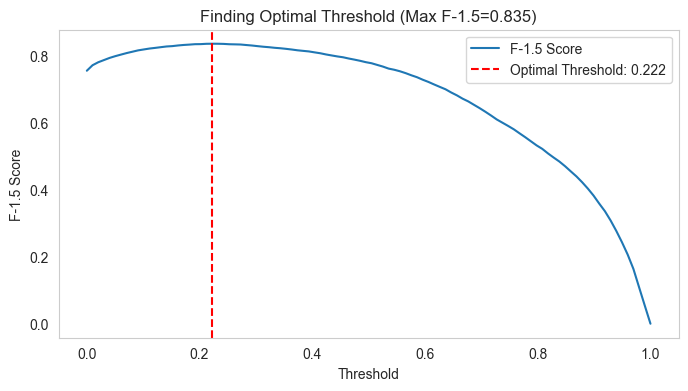

Optimal threshold: 0.2222


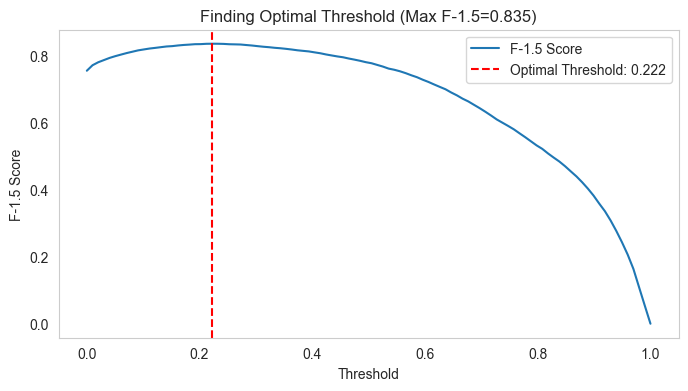

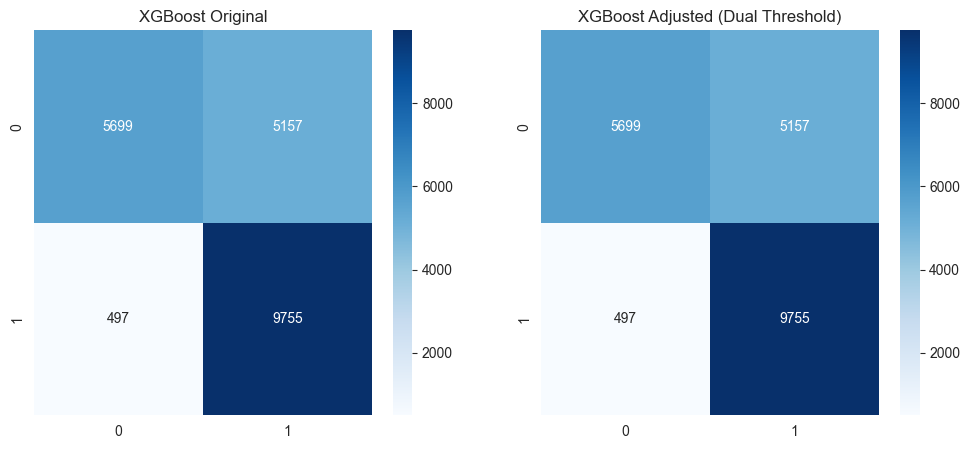


Training LightGBM...


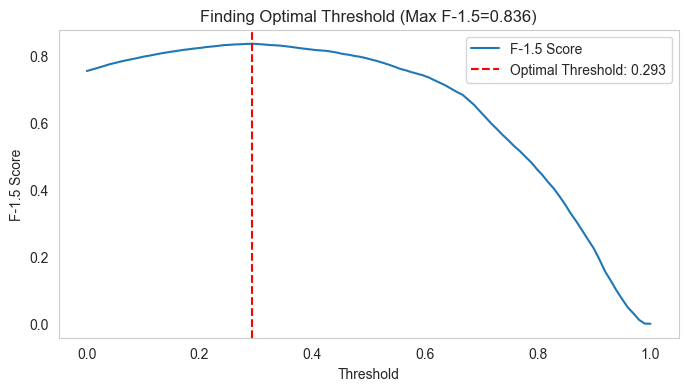

Optimal threshold: 0.2929


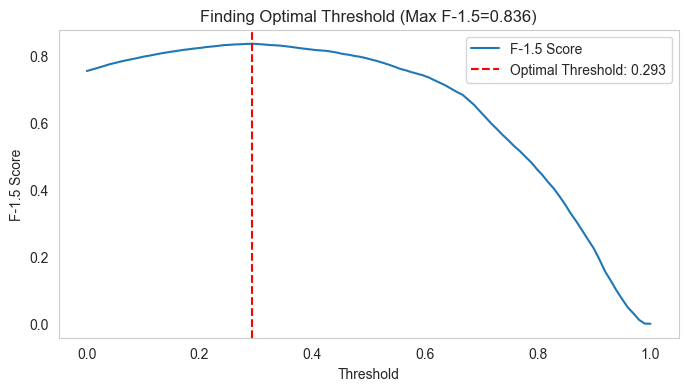

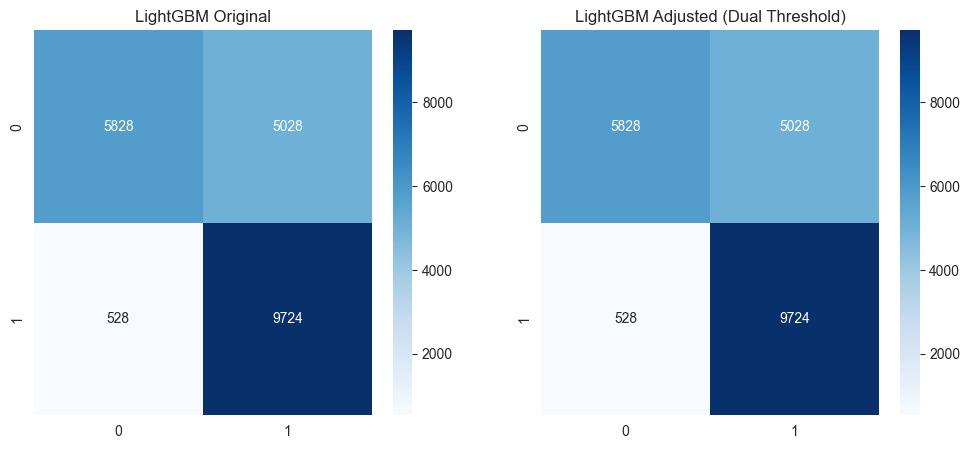


Training CatBoost...


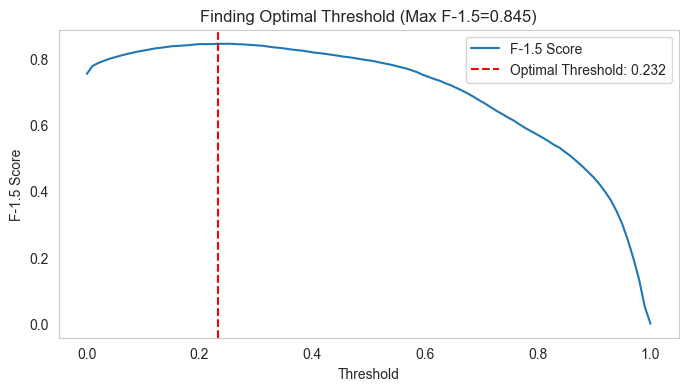

Optimal threshold: 0.2323


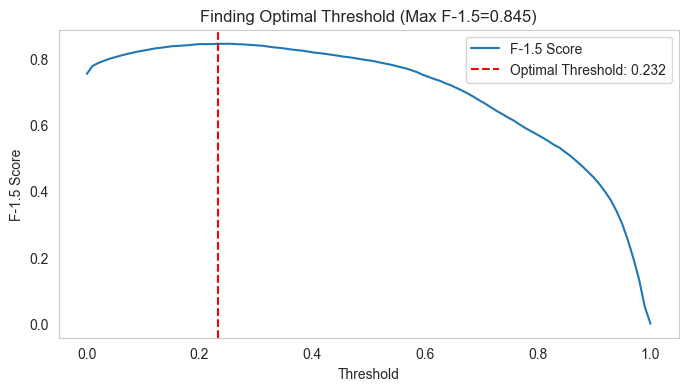

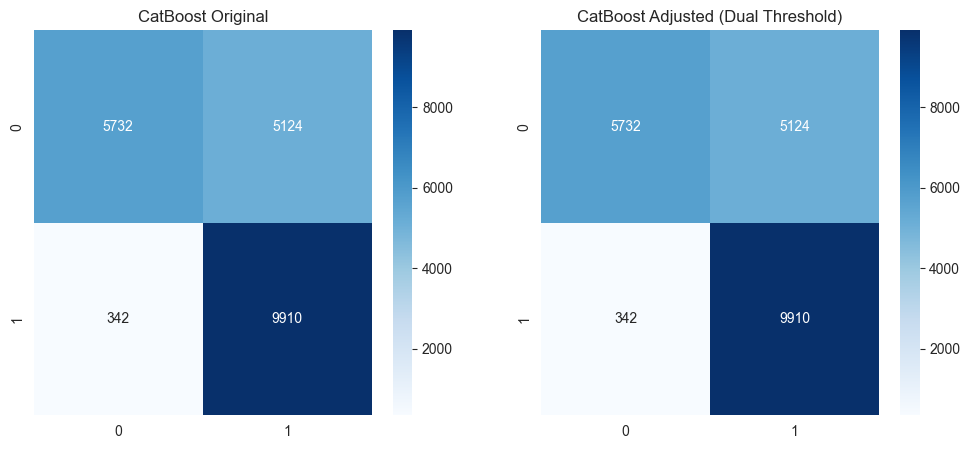


Training RandomForest...


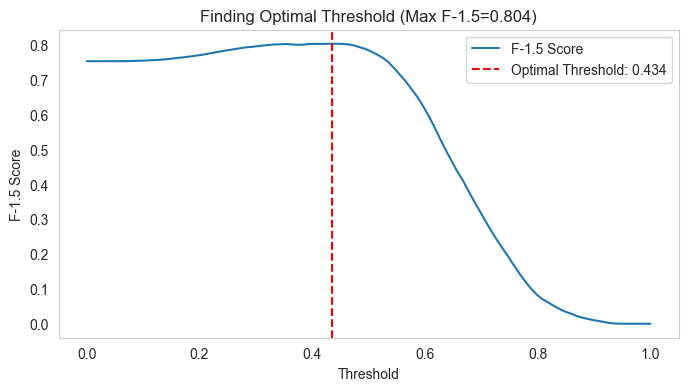

Optimal threshold: 0.4343


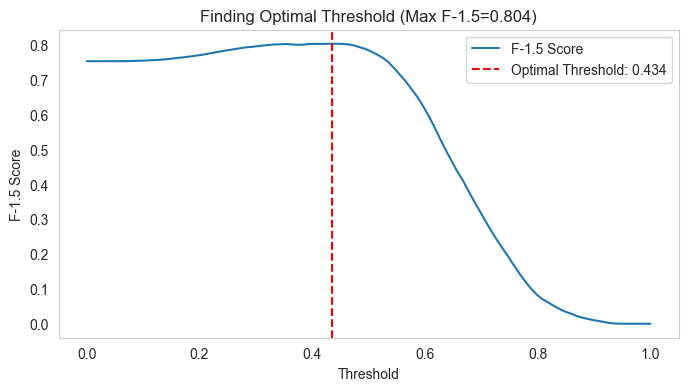

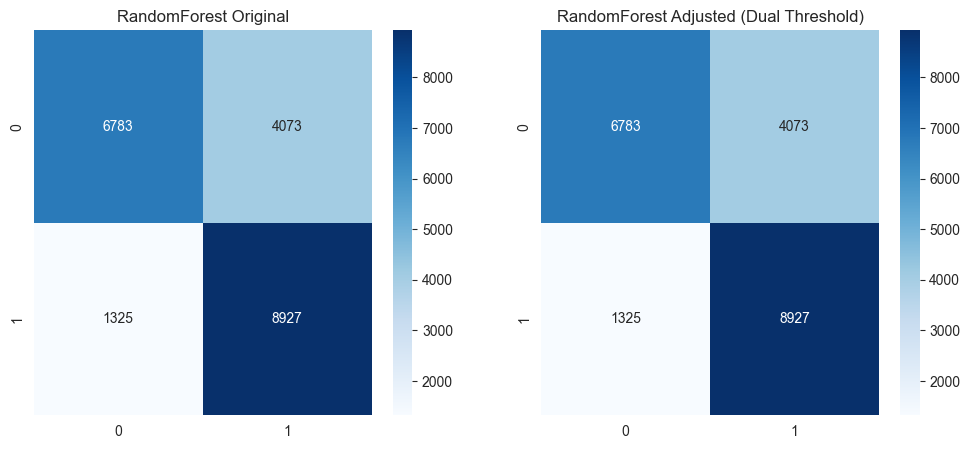


Training LogisticRegression...


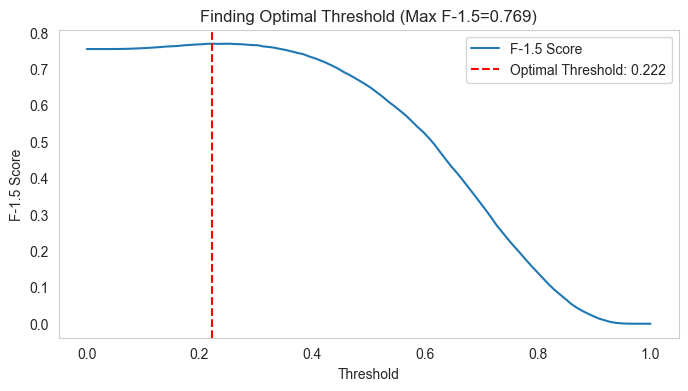

Optimal threshold: 0.2222


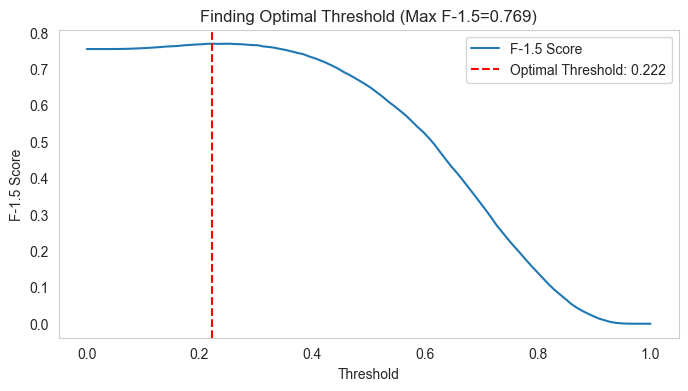

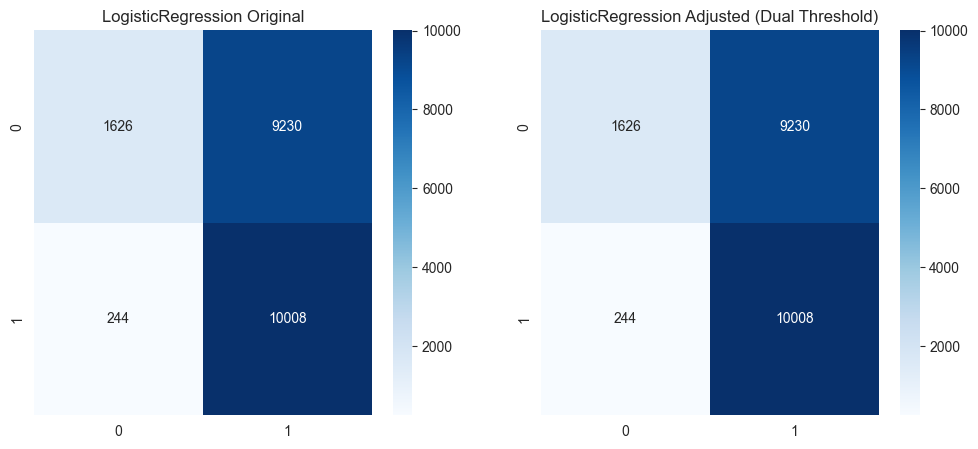


Training SVM...


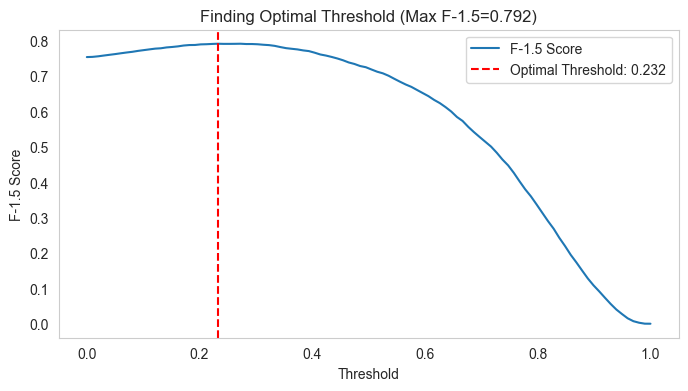

Optimal threshold: 0.2323


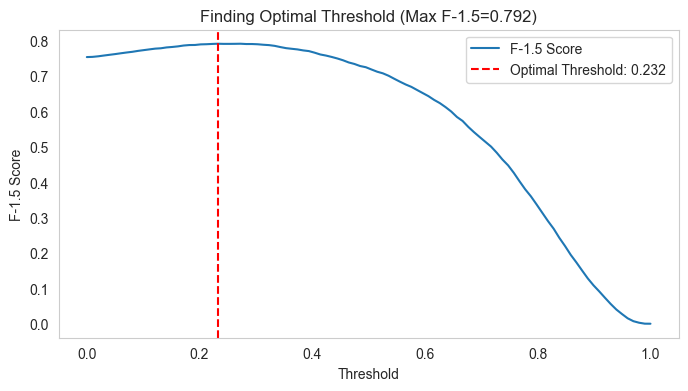

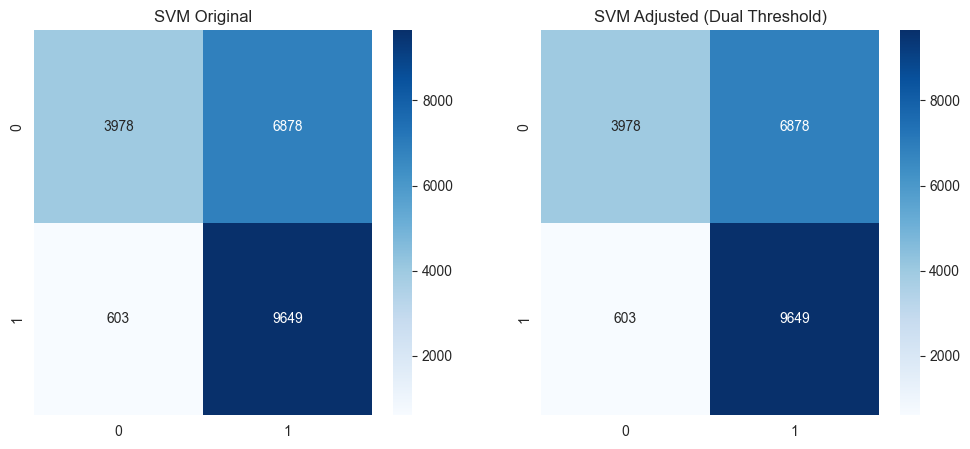


Training Ensemble...


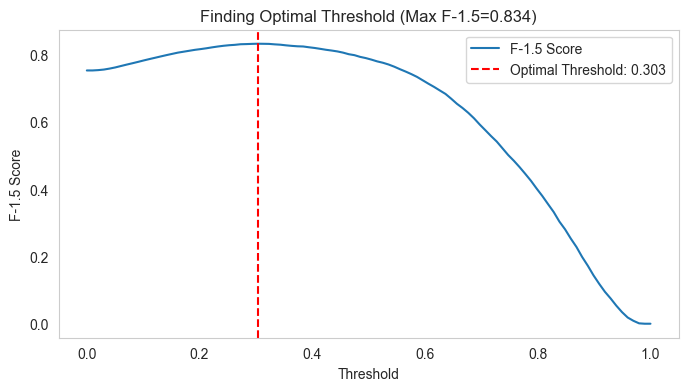

Optimal threshold: 0.3030


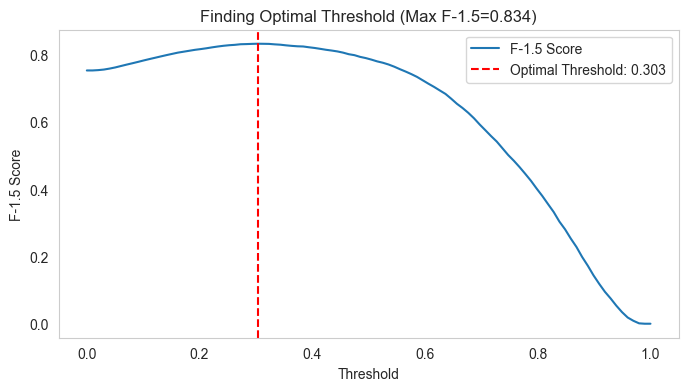

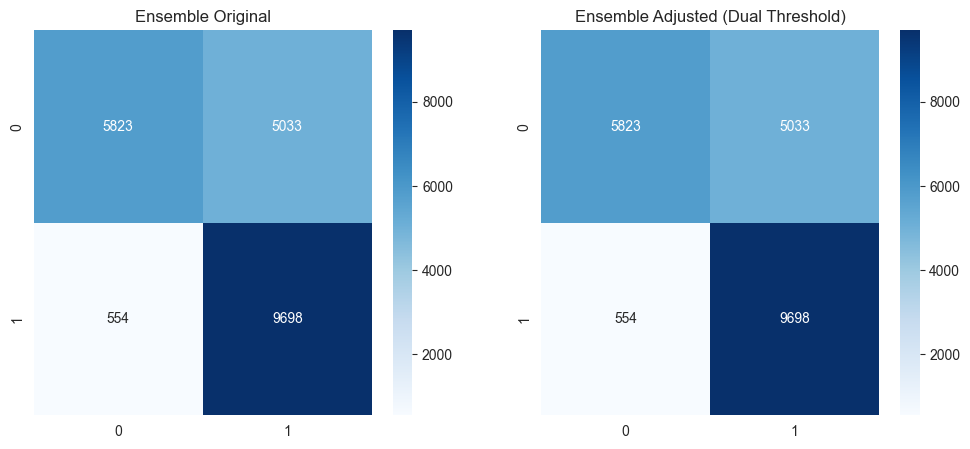


Model Comparison:
                Model  Accuracy  Precision    Recall        F1   ROC AUC  \
2            CatBoost  0.741046   0.659173  0.966641  0.783833  0.899650   
1            LightGBM  0.736782   0.659165  0.948498  0.777796  0.883976   
6            Ensemble  0.735314   0.658340  0.945962  0.776368  0.886017   
0             XGBoost  0.732139   0.654171  0.951522  0.775314  0.888035   
3        RandomForest  0.744268   0.686692  0.870757  0.767848  0.851059   
5                 SVM  0.645585   0.583833  0.941182  0.720639  0.797029   
4  LogisticRegression  0.551165   0.520220  0.976200  0.678739  0.717608   

     PR AUC  Optimal Threshold  Adj_Precision  Adj_Recall    Adj_F1  \
2  0.904372           0.232323       0.659173    0.966641  0.783833   
1  0.886693           0.292929       0.659165    0.948498  0.777796   
6  0.889054           0.303030       0.658340    0.945962  0.776368   
0  0.892815           0.222222       0.654171    0.951522  0.775314   
3  0.848843      

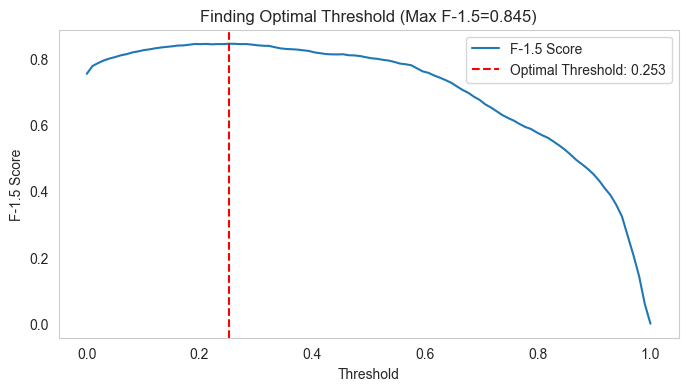

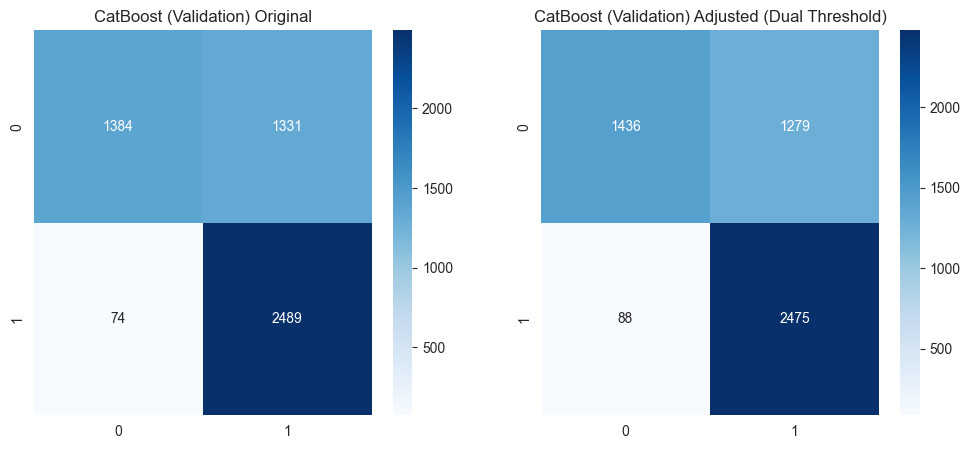


Validation Metrics:
   Accuracy  Precision    Recall        F1   ROC AUC    PR AUC  \
0  0.733801   0.651571  0.971128  0.779884  0.902295  0.907368   

   Optimal Threshold  Adj_Precision  Adj_Recall  Adj_F1  Adj_Threshold_Low  \
0           0.252525       0.659297    0.965665  0.7836           0.252525   

   Adj_Threshold_High  
0                 0.6  


In [26]:
# Get all drug and symptom columns
all_drug_columns = [col for col in df.columns if col.startswith('Drug_') and col != 'Drug_Count']
all_symptom_columns = [col for col in df.columns if col.startswith('Symptom_')]

# Define feature columns
useful_features = [
    # Demographic
    'Age_at_Diagnosis', 'BMI', 'Urban_Rural', 'Insurance_Type',
    
    # Cancer characteristics
    'Cancer_Type', 'Stage_Ordinal', 'Tumor_Size', 'Recurrence_Status',
    
    # Treatment related
    'Had_Surgery', 'Had_Chemotherapy', 'Radiation_Sessions',
    'Immunotherapy', 'Targeted_Therapy', 'Drug_Count',
    
    # All drugs and symptoms
    *all_drug_columns,
    *all_symptom_columns,
    
    # Lifestyle
    'Smoking_History', 'Alcohol_Use',
    
    # Temporal
    'Diagnosis_Year'
]

df = df.dropna(subset=['Age_at_Diagnosis'])

# Separate features and target
X = df[useful_features]
y = df['label']

# Define categorical and numerical features
categorical_features = [
    'Urban_Rural', 'Insurance_Type', 'Cancer_Type',
    'Recurrence_Status', 'Immunotherapy', 'Targeted_Therapy',
    'Smoking_History', 'Alcohol_Use'
]

numerical_features = [
    'Age_at_Diagnosis', 'BMI', 'Stage_Ordinal', 'Tumor_Size',
    'Radiation_Sessions', 'Drug_Count',
    'Diagnosis_Year'
]

# Binary features (drugs and symptoms)
binary_features = all_drug_columns + all_symptom_columns
binary_features = [col for col in binary_features 
                   if not col == 'Drug_Count' and 
                   (col.startswith('Drug_') or col.startswith('Symptom_'))]

# Preprocessing pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features),
        ('binary', 'passthrough', binary_features)
    ],
    verbose_feature_names_out=False  # This prevents the prefixes
)

# Split into train and validation sets (80-20)
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y)

# Define base models without pipelines
base_models = {
    'XGBoost': XGBClassifier(
        random_state=42,
        eval_metric='logloss',
        scale_pos_weight=0.9,  # Slightly reduced from 0.8
        max_depth=4,  # Reduced from 5
        subsample=0.7,
        colsample_bytree=0.7,
        min_child_weight=3,  # Added to prevent overfitting
        n_jobs=-1
    ),
    'LightGBM': LGBMClassifier(
        random_state=42,
        is_unbalance=True,
        max_depth=4,  # Reduced from 5
        feature_fraction=0.8,
        lambda_l1=0.2,
        min_data_in_leaf=20,  # Added
        verbosity=-1
    ),
    'CatBoost': CatBoostClassifier(
        random_state=42,
        auto_class_weights='Balanced',
        depth=6,
        l2_leaf_reg=3,
        verbose=0
    ),
    'RandomForest': RandomForestClassifier(
        random_state=42,
        class_weight='balanced_subsample',
        max_depth=7,
        n_jobs=-1
    ),
    'LogisticRegression': LogisticRegression(
        class_weight='balanced',
        penalty='l1',
        solver='liblinear',
        C=0.1,
        random_state=42
    ),
    'SVM': SVC(
        class_weight='balanced',
        probability=True,
        kernel='rbf',
        C=1.0,
        gamma='scale',
        random_state=42
    )
}

# Create complete pipelines for each model
models = {}
for name, model in base_models.items():
    if name in ['LogisticRegression', 'SVM']:
        # These need StandardScaler first
        models[name] = imbPipeline([
            ('preprocessor', preprocessor),
            ('scaler', StandardScaler(with_mean=False)),  # with_mean=False for sparse data
            ('smote', SMOTE(random_state=42)),
            ('feature_selection', SelectFromModel(
                LGBMClassifier(random_state=42, n_jobs=-1, verbose=-1),
                threshold='median'
            )),
            ('model', model)
        ])
    else:
        models[name] = imbPipeline([
            ('preprocessor', preprocessor),
            ('smote', SMOTE(random_state=42)),
            ('feature_selection', SelectFromModel(
                LGBMClassifier(random_state=42, n_jobs=-1, verbose=-1),
                threshold='median'
            )),
            ('model', model)
        ])

# Add ensemble model
models['Ensemble'] = VotingClassifier(
    estimators=[
        ('xgb', models['XGBoost']),
        ('lgbm', models['LightGBM']),
        ('logreg', models['LogisticRegression'])
    ],
    voting='soft',
    weights=[0.4, 0.4, 0.2]
)


from sklearn.metrics import fbeta_score

def find_optimal_threshold(y_true, y_proba, beta=1.5, n_thresholds=100):
    """
    Find the optimal threshold that maximizes F-beta score, 
    with adjustable emphasis on precision vs recall.
    
    Parameters:
    y_true : array-like, true labels
    y_proba : array-like, predicted probabilities
    beta : float, beta value for F-beta score (default 1.5)
           Higher beta emphasizes recall more
    n_thresholds : int, number of thresholds to evaluate (default 100)
    
    Returns:
    float: Optimal threshold value
    """
    # Generate thresholds to evaluate
    thresholds = np.linspace(0, 1, n_thresholds)
    
    # Calculate F-beta score for each threshold
    f_scores = []
    for threshold in thresholds:
        y_pred = (y_proba > threshold).astype(int)
        f_scores.append(fbeta_score(y_true, y_pred, beta=beta))
    
    # Find the threshold that gives maximum F-beta score
    optimal_idx = np.argmax(f_scores)
    optimal_threshold = thresholds[optimal_idx]
    
    # Plot the F-beta scores across thresholds
    plt.figure(figsize=(8, 4))
    plt.plot(thresholds, f_scores, label=f'F-{beta} Score')
    plt.axvline(optimal_threshold, color='r', linestyle='--', 
                label=f'Optimal Threshold: {optimal_threshold:.3f}')
    plt.xlabel('Threshold')
    plt.ylabel(f'F-{beta} Score')
    plt.title(f'Finding Optimal Threshold (Max F-{beta}={np.max(f_scores):.3f})')
    plt.legend()
    plt.grid()
    plt.show()
    
    return optimal_threshold

def evaluate_model(y_true, y_pred, y_proba, model_name):
    """Enhanced evaluation with balanced adjustments"""
    # Original metrics
    metrics = {
        'Accuracy': accuracy_score(y_true, y_pred),
        'Precision': precision_score(y_true, y_pred),
        'Recall': recall_score(y_true, y_pred),
        'F1': f1_score(y_true, y_pred),
        'ROC AUC': roc_auc_score(y_true, y_proba),
        'PR AUC': average_precision_score(y_true, y_proba)
    }
    
    # Find optimal threshold
    optimal_threshold = find_optimal_threshold(y_true, y_proba)
    metrics['Optimal Threshold'] = optimal_threshold
    
    # New balanced adjustment
    # For alive predictions (1), require higher confidence (>0.6)
    # For deceased predictions (0), use original threshold
    y_pred_adj = np.where(
        y_proba > 0.6,  # Higher threshold for alive predictions
        1,
        (y_proba > optimal_threshold).astype(int)
    )
    
    # Adjusted metrics
    adj_metrics = {
        'Adj_Precision': precision_score(y_true, y_pred_adj),
        'Adj_Recall': recall_score(y_true, y_pred_adj),
        'Adj_F1': f1_score(y_true, y_pred_adj),
        'Adj_Threshold_Low': optimal_threshold,
        'Adj_Threshold_High': 0.6
    }
    
    # Confusion matrix
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'{model_name} Original')
    
    plt.subplot(1, 2, 2)
    cm_adj = confusion_matrix(y_true, y_pred_adj)
    sns.heatmap(cm_adj, annot=True, fmt='d', cmap='Blues')
    plt.title(f'{model_name} Adjusted (Dual Threshold)')
    plt.show()
    
    return {**metrics, **adj_metrics}

# Model Training and Evaluation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
results = []

for name, pipeline in models.items():
    print(f"\n{'='*50}\nTraining {name}...\n{'='*50}")
    
    # Train on full training set
    pipeline.fit(X_train, y_train)
    
    # Get probabilities using cross-validation
    y_proba = cross_val_predict(pipeline, X_train, y_train, 
                              cv=cv, method='predict_proba')[:, 1]
    
    # Find optimal threshold
    optimal_threshold = find_optimal_threshold(y_train, y_proba)
    print(f"Optimal threshold: {optimal_threshold:.4f}")
    
    # Evaluate
    y_pred = (y_proba > optimal_threshold).astype(int)
    metrics = evaluate_model(y_train, y_pred, y_proba, name)
    
    results.append({
        'Model': name,
        **metrics
    })

# Final Model Comparison
results_df = pd.DataFrame(results)
print("\nModel Comparison:")
print(results_df.sort_values('Adj_F1', ascending=False))

# Evaluate best model on validation set
best_model_name = results_df.sort_values('Adj_F1', ascending=False).iloc[0]['Model']
best_model = models[best_model_name]

print(f"\nEvaluating best model ({best_model_name}) on validation set...")
y_val_proba = best_model.predict_proba(X_val)[:, 1]
y_val_pred = (y_val_proba > results_df[results_df['Model'] == best_model_name]['Optimal Threshold'].values[0]).astype(int)
val_metrics = evaluate_model(y_val, y_val_pred, y_val_proba, f"{best_model_name} (Validation)")

print("\nValidation Metrics:")
print(pd.DataFrame([val_metrics]))


Training CatBoost...


<Figure size 1000x400 with 0 Axes>

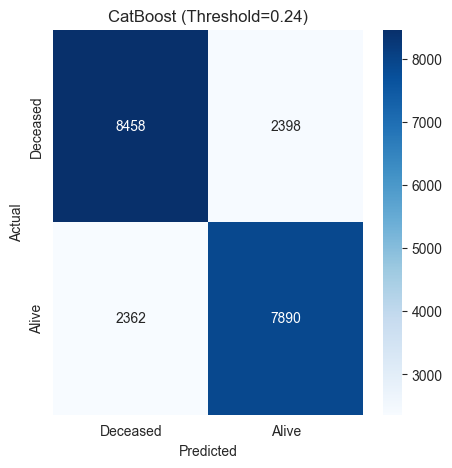

              precision    recall  f1-score   support

    Deceased       0.78      0.78      0.78     10856
       Alive       0.77      0.77      0.77     10252

    accuracy                           0.77     21108
   macro avg       0.77      0.77      0.77     21108
weighted avg       0.77      0.77      0.77     21108


Model Comparison (sorted by Accuracy):
      Model  Accuracy  Precision    Recall        F1   ROC AUC    PR AUC  \
0  CatBoost  0.774493   0.766913  0.769606  0.768257  0.868714  0.873709   

   Threshold  
0   0.242424  

Evaluating CatBoost on Validation Set


<Figure size 1000x400 with 0 Axes>

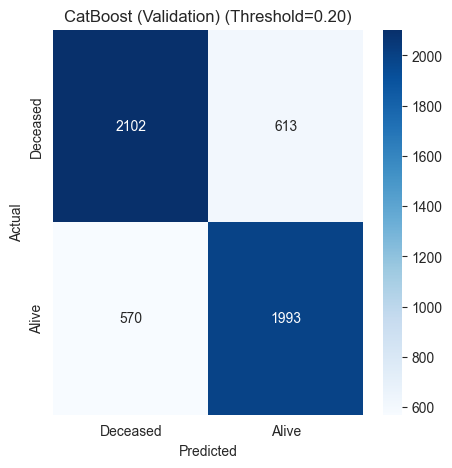

              precision    recall  f1-score   support

    Deceased       0.79      0.77      0.78      2715
       Alive       0.76      0.78      0.77      2563

    accuracy                           0.78      5278
   macro avg       0.78      0.78      0.78      5278
weighted avg       0.78      0.78      0.78      5278



In [80]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_predict
from sklearn.metrics import (accuracy_score, precision_score, recall_score, 
                           f1_score, roc_auc_score, average_precision_score, 
                           confusion_matrix, classification_report)
from imblearn.pipeline import Pipeline as imbPipeline
from imblearn.over_sampling import SMOTE
from sklearn.feature_selection import SelectFromModel
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

# Data Preparation (unchanged)
# all_drug_columns = [col for col in df.columns if col.startswith('Drug_') and col != 'Drug_Count']
# all_symptom_columns = [col for col in df.columns if col.startswith('Symptom_')]

# useful_features = [
#     'Age_at_Diagnosis', 'BMI', 'Urban_Rural', 'Insurance_Type',
#     'Cancer_Type', 'Stage_Ordinal', 'Tumor_Size', 'Recurrence_Status',
#     'Had_Surgery', 'Had_Chemotherapy', 'Radiation_Sessions',
#     'Immunotherapy', 'Targeted_Therapy', 'Drug_Count',
#     *all_drug_columns, *all_symptom_columns,
#     'Smoking_History', 'Alcohol_Use', 'Diagnosis_Year'
# ]

useful_features = [
    'Age_at_Diagnosis', 'Stage_Ordinal',
    'Cancer_Type', 'BMI', 'Tumor_Size', 'Drug_Count',
    'Smoking_History', 'Alcohol_Use',
]

df = df.dropna(subset=['Age_at_Diagnosis'])
X = df[useful_features]
y = df['label']

# categorical_features = [
#     'Urban_Rural', 'Insurance_Type', 'Cancer_Type',
#     'Recurrence_Status', 'Immunotherapy', 'Targeted_Therapy',
#     'Smoking_History', 'Alcohol_Use'
# ]

categorical_features = [
    'Cancer_Type',
    'Smoking_History', 'Alcohol_Use'
]

# numerical_features = [
#     'Age_at_Diagnosis', 'BMI', 'Stage_Ordinal', 'Tumor_Size',
#     'Radiation_Sessions', 'Drug_Count', 'Diagnosis_Year'
# ]

numerical_features = [
    'Age_at_Diagnosis', 'BMI', 'Stage_Ordinal','Tumor_Size',
    'Drug_Count'
]

# binary_features = [col for col in all_drug_columns + all_symptom_columns 
#                   if not col == 'Drug_Count' and 
#                   (col.startswith('Drug_') or col.startswith('Symptom_'))]

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features),
        # ('binary', 'passthrough', binary_features)
    ],
    verbose_feature_names_out=False
)

X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y)

# Model Definitions (unchanged)
base_models = {
    # 'XGBoost': XGBClassifier(random_state=42, eval_metric='logloss', scale_pos_weight=0.9,
    #                         max_depth=4, subsample=0.7, colsample_bytree=0.7, min_child_weight=3),
    # 'LightGBM': LGBMClassifier(random_state=42, is_unbalance=True, max_depth=4,
    #                          feature_fraction=0.8, lambda_l1=0.2, min_data_in_leaf=20),
    'CatBoost': CatBoostClassifier(random_state=42, auto_class_weights='Balanced',
                                 depth=6, l2_leaf_reg=3, verbose=0),
    # 'RandomForest': RandomForestClassifier(random_state=42, class_weight='balanced_subsample',
    #                                     max_depth=7, n_jobs=-1),
    # 'LogisticRegression': LogisticRegression(class_weight='balanced', penalty='l1',
    #                                        solver='liblinear', C=0.1, random_state=42),
}

models = {}
for name, model in base_models.items():
    if name in ['LogisticRegression', 'SVM']:
        models[name] = imbPipeline([
            ('preprocessor', preprocessor),
            ('scaler', StandardScaler(with_mean=False)),
            ('smote', SMOTE(random_state=42)),
            ('feature_selection', SelectFromModel(LGBMClassifier(random_state=42), threshold='median')),
            ('model', model)
        ])
    else:
        models[name] = imbPipeline([
            ('preprocessor', preprocessor),
            ('smote', SMOTE(random_state=42)),
            ('feature_selection', SelectFromModel(LGBMClassifier(random_state=42), threshold='median')),
            ('model', model)
        ])

# models['Ensemble'] = VotingClassifier(
#     estimators=[('xgb', models['XGBoost']), ('lgbm', models['LightGBM']), ('logreg', models['LogisticRegression'])],
#     voting='soft', weights=[0.4, 0.4, 0.2]
# )

# Improved Evaluation Functions
def find_optimal_threshold(y_true, y_proba, beta=1.5):
    thresholds = np.linspace(0, 1, 100)
    f_scores = [fbeta_score(y_true, (y_proba > t).astype(int), beta=beta) for t in thresholds]
    return thresholds[np.argmax(f_scores)]

def plot_confusion_matrix(y_true, y_pred, title, ax=None):
    cm = confusion_matrix(y_true, y_pred)
    if ax is None:
        fig, ax = plt.subplots(figsize=(5,5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax,
               xticklabels=['Deceased', 'Alive'],
               yticklabels=['Deceased', 'Alive'])
    ax.set_title(title)
    ax.set_xlabel('Predicted')
    ax.set_ylabel('Actual')

def evaluate_model(y_true, y_proba, model_name):
    # Find optimal threshold
    threshold = find_optimal_threshold(y_true, y_proba)
    y_pred = (y_proba > 0.5).astype(int)
    
    # Calculate metrics
    metrics = {
        'Accuracy': accuracy_score(y_true, y_pred),
        'Precision': precision_score(y_true, y_pred),
        'Recall': recall_score(y_true, y_pred),
        'F1': f1_score(y_true, y_pred),
        'ROC AUC': roc_auc_score(y_true, y_proba),
        'PR AUC': average_precision_score(y_true, y_proba),
        'Threshold': threshold
    }
    
    # Plot confusion matrix
    plt.figure(figsize=(10, 4))
    plot_confusion_matrix(y_true, y_pred, f'{model_name} (Threshold={threshold:.2f})')
    plt.show()
    
    # Print classification report
    print(classification_report(y_true, y_pred, target_names=['Deceased', 'Alive']))
    
    return metrics

# Model Training and Evaluation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
results = []

for name, pipeline in models.items():
    print(f"\n{'='*50}\nTraining {name}...\n{'='*50}")
    
    # Get cross-validated probabilities
    y_proba = cross_val_predict(pipeline, X_train, y_train, cv=cv, method='predict_proba')[:, 1]
    
    # Evaluate
    metrics = evaluate_model(y_train, y_proba, name)
    results.append({'Model': name, **metrics})

# Final Evaluation
results_df = pd.DataFrame(results)
print("\nModel Comparison (sorted by Accuracy):")
print(results_df.sort_values('Accuracy', ascending=False))

# Evaluate best model on validation set
best_model_name = results_df.sort_values('Accuracy', ascending=False).iloc[0]['Model']
best_model = models[best_model_name]
best_model.fit(X_train, y_train)

print(f"\n{'='*50}\nEvaluating {best_model_name} on Validation Set\n{'='*50}")
y_val_proba = best_model.predict_proba(X_val)[:, 1]
val_metrics = evaluate_model(y_val, y_val_proba, f"{best_model_name} (Validation)")



CatBoost CV | Params: {'depth': 4, 'l2_leaf_reg': 2}


<Figure size 500x400 with 0 Axes>

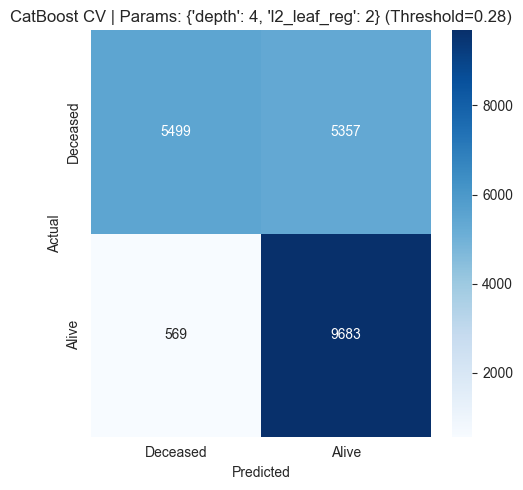

CatBoost CV | Params: {'depth': 4, 'l2_leaf_reg': 2} Classification Report:
              precision    recall  f1-score   support

    Deceased       0.91      0.51      0.65     10856
       Alive       0.64      0.94      0.77     10252

    accuracy                           0.72     21108
   macro avg       0.78      0.73      0.71     21108
weighted avg       0.78      0.72      0.71     21108


CatBoost CV + SMOTE | Params: {'depth': 4, 'l2_leaf_reg': 2}


<Figure size 500x400 with 0 Axes>

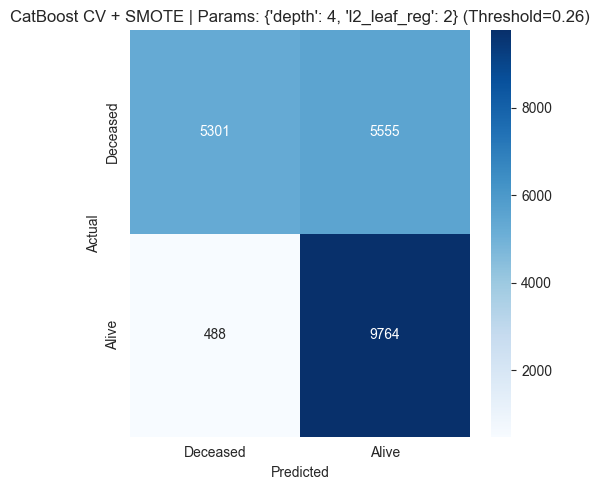

CatBoost CV + SMOTE | Params: {'depth': 4, 'l2_leaf_reg': 2} Classification Report:
              precision    recall  f1-score   support

    Deceased       0.92      0.49      0.64     10856
       Alive       0.64      0.95      0.76     10252

    accuracy                           0.71     21108
   macro avg       0.78      0.72      0.70     21108
weighted avg       0.78      0.71      0.70     21108


CatBoost CV | Params: {'depth': 6, 'l2_leaf_reg': 3}


<Figure size 500x400 with 0 Axes>

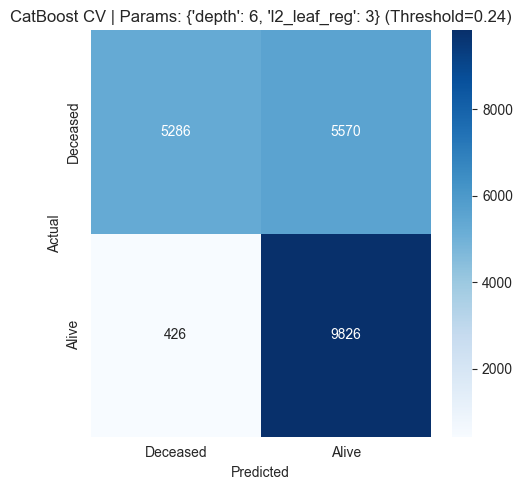

CatBoost CV | Params: {'depth': 6, 'l2_leaf_reg': 3} Classification Report:
              precision    recall  f1-score   support

    Deceased       0.93      0.49      0.64     10856
       Alive       0.64      0.96      0.77     10252

    accuracy                           0.72     21108
   macro avg       0.78      0.72      0.70     21108
weighted avg       0.79      0.72      0.70     21108


CatBoost CV + SMOTE | Params: {'depth': 6, 'l2_leaf_reg': 3}


<Figure size 500x400 with 0 Axes>

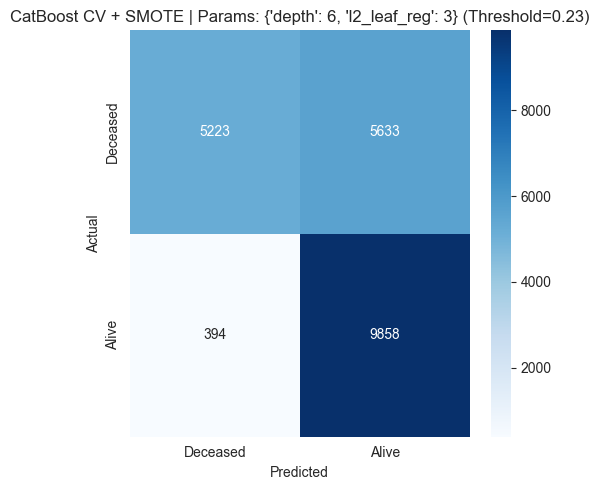

CatBoost CV + SMOTE | Params: {'depth': 6, 'l2_leaf_reg': 3} Classification Report:
              precision    recall  f1-score   support

    Deceased       0.93      0.48      0.63     10856
       Alive       0.64      0.96      0.77     10252

    accuracy                           0.71     21108
   macro avg       0.78      0.72      0.70     21108
weighted avg       0.79      0.71      0.70     21108


CatBoost CV | Params: {'depth': 8, 'l2_leaf_reg': 5}


<Figure size 500x400 with 0 Axes>

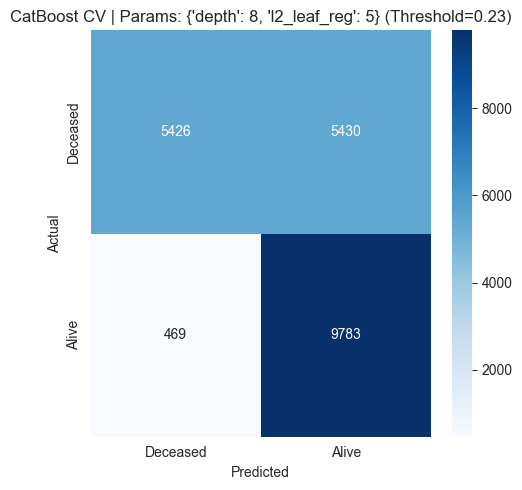

CatBoost CV | Params: {'depth': 8, 'l2_leaf_reg': 5} Classification Report:
              precision    recall  f1-score   support

    Deceased       0.92      0.50      0.65     10856
       Alive       0.64      0.95      0.77     10252

    accuracy                           0.72     21108
   macro avg       0.78      0.73      0.71     21108
weighted avg       0.79      0.72      0.71     21108


CatBoost CV + SMOTE | Params: {'depth': 8, 'l2_leaf_reg': 5}


<Figure size 500x400 with 0 Axes>

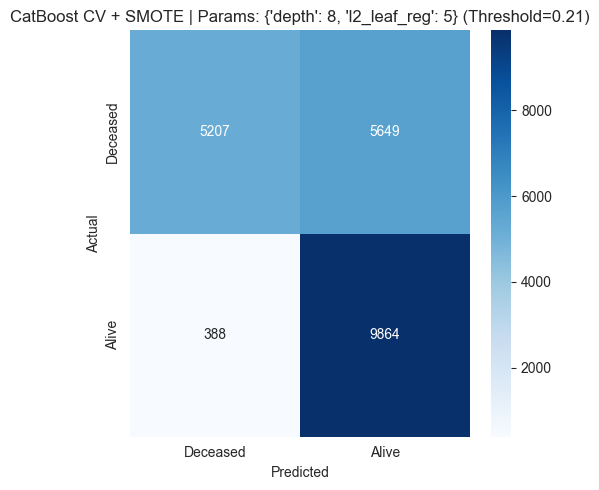

CatBoost CV + SMOTE | Params: {'depth': 8, 'l2_leaf_reg': 5} Classification Report:
              precision    recall  f1-score   support

    Deceased       0.93      0.48      0.63     10856
       Alive       0.64      0.96      0.77     10252

    accuracy                           0.71     21108
   macro avg       0.78      0.72      0.70     21108
weighted avg       0.79      0.71      0.70     21108


CatBoost CV | Params: {'depth': 6, 'l2_leaf_reg': 3, 'learning_rate': 0.03}


<Figure size 500x400 with 0 Axes>

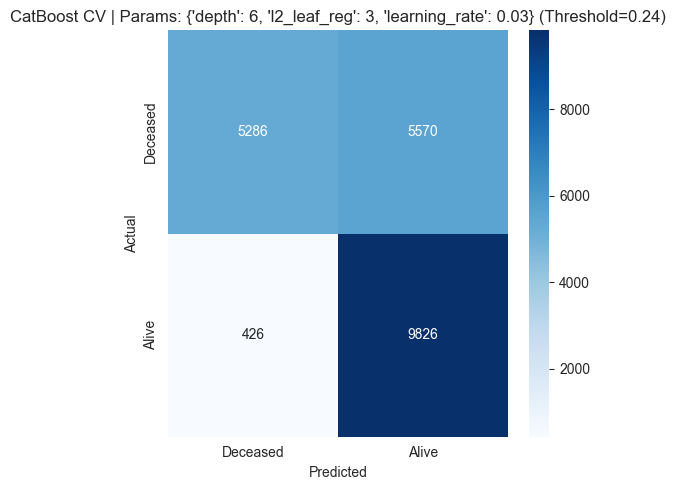

CatBoost CV | Params: {'depth': 6, 'l2_leaf_reg': 3, 'learning_rate': 0.03} Classification Report:
              precision    recall  f1-score   support

    Deceased       0.93      0.49      0.64     10856
       Alive       0.64      0.96      0.77     10252

    accuracy                           0.72     21108
   macro avg       0.78      0.72      0.70     21108
weighted avg       0.79      0.72      0.70     21108


CatBoost CV + SMOTE | Params: {'depth': 6, 'l2_leaf_reg': 3, 'learning_rate': 0.03}


<Figure size 500x400 with 0 Axes>

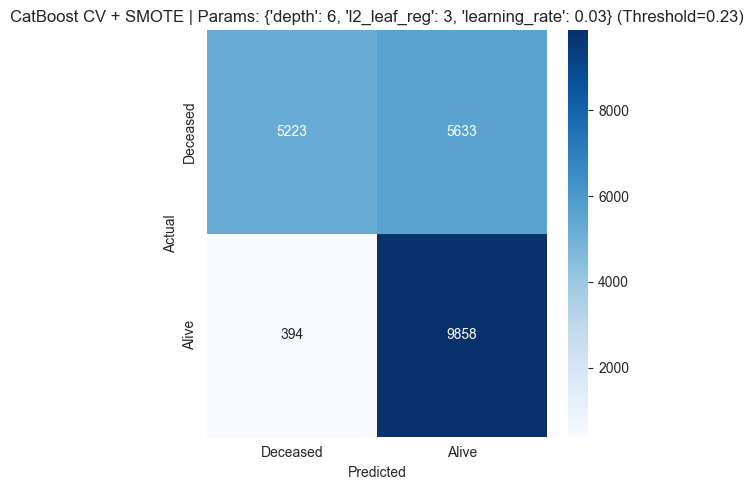

CatBoost CV + SMOTE | Params: {'depth': 6, 'l2_leaf_reg': 3, 'learning_rate': 0.03} Classification Report:
              precision    recall  f1-score   support

    Deceased       0.93      0.48      0.63     10856
       Alive       0.64      0.96      0.77     10252

    accuracy                           0.71     21108
   macro avg       0.78      0.72      0.70     21108
weighted avg       0.79      0.71      0.70     21108


Top CatBoost Configurations by Accuracy:
                                               Model  Accuracy  Precision  \
4  CatBoost CV | Params: {'depth': 8, 'l2_leaf_re...  0.720532   0.643068   
0  CatBoost CV | Params: {'depth': 4, 'l2_leaf_re...  0.719253   0.643816   
2  CatBoost CV | Params: {'depth': 6, 'l2_leaf_re...  0.715937   0.638218   
6  CatBoost CV | Params: {'depth': 6, 'l2_leaf_re...  0.715937   0.638218   
3  CatBoost CV + SMOTE | Params: {'depth': 6, 'l2...  0.714468   0.636370   

     Recall        F1   ROC AUC    PR AUC  Threshold  
4  0.9

In [54]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_predict
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                             f1_score, roc_auc_score, average_precision_score,
                             confusion_matrix, classification_report, fbeta_score)
from imblearn.pipeline import Pipeline as imbPipeline
from imblearn.over_sampling import SMOTE
from sklearn.feature_selection import SelectFromModel
from catboost import CatBoostClassifier

# Assume df is your DataFrame and 'label' is the target column

# Define feature columns
all_drug_columns = [col for col in df.columns if col.startswith('Drug_') and col != 'Drug_Count']
all_symptom_columns = [col for col in df.columns if col.startswith('Symptom_')]

useful_features = [
    'Age_at_Diagnosis', 'BMI', 'Urban_Rural', 'Insurance_Type',
    'Cancer_Type', 'Stage_Ordinal', 'Tumor_Size', 'Recurrence_Status',
    'Had_Surgery', 'Had_Chemotherapy', 'Radiation_Sessions',
    'Immunotherapy', 'Targeted_Therapy', 'Drug_Count',
    *all_drug_columns, *all_symptom_columns,
    'Smoking_History', 'Alcohol_Use', 'Diagnosis_Year'
]

df = df.dropna(subset=['Age_at_Diagnosis'])
X = df[useful_features]
y = df['label']

categorical_features = [
    'Urban_Rural', 'Insurance_Type', 'Cancer_Type',
    'Recurrence_Status', 'Immunotherapy', 'Targeted_Therapy',
    'Smoking_History', 'Alcohol_Use'
]

numerical_features = [
    'Age_at_Diagnosis', 'BMI', 'Stage_Ordinal', 'Tumor_Size',
    'Radiation_Sessions', 'Drug_Count', 'Diagnosis_Year'
]

binary_features = [col for col in all_drug_columns + all_symptom_columns]

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features),
        ('binary', 'passthrough', binary_features)
    ],
    verbose_feature_names_out=False
)

X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42)

# Evaluation Functions
def find_optimal_threshold(y_true, y_proba, beta=1.5):
    thresholds = np.linspace(0, 1, 100)
    f_scores = [fbeta_score(y_true, (y_proba > t).astype(int), beta=beta) for t in thresholds]
    return thresholds[np.argmax(f_scores)]

def plot_confusion_matrix(y_true, y_pred, title, ax=None):
    cm = confusion_matrix(y_true, y_pred)
    if ax is None:
        fig, ax = plt.subplots(figsize=(5, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax,
                xticklabels=['Deceased', 'Alive'],
                yticklabels=['Deceased', 'Alive'])
    ax.set_title(title)
    ax.set_xlabel('Predicted')
    ax.set_ylabel('Actual')

def evaluate_model(y_true, y_proba, model_name):
    threshold = find_optimal_threshold(y_true, y_proba)
    y_pred = (y_proba > threshold).astype(int)

    metrics = {
        'Accuracy': accuracy_score(y_true, y_pred),
        'Precision': precision_score(y_true, y_pred),
        'Recall': recall_score(y_true, y_pred),
        'F1': f1_score(y_true, y_pred),
        'ROC AUC': roc_auc_score(y_true, y_proba),
        'PR AUC': average_precision_score(y_true, y_proba),
        'Threshold': threshold
    }

    plt.figure(figsize=(5, 4))
    plot_confusion_matrix(y_true, y_pred, f'{model_name} (Threshold={threshold:.2f})')
    plt.tight_layout()
    plt.show()

    print(f"{model_name} Classification Report:")
    print(classification_report(y_true, y_pred, target_names=['Deceased', 'Alive']))

    return metrics

# CatBoost hyperparameters to try
catboost_params_list = [
    {'depth': 4, 'l2_leaf_reg': 2},
    {'depth': 6, 'l2_leaf_reg': 3},
    {'depth': 8, 'l2_leaf_reg': 5},
    {'depth': 6, 'l2_leaf_reg': 3, 'learning_rate': 0.03},
]

results = []
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

for i, params in enumerate(catboost_params_list):
    for smote_flag in [False, True]:
        label = f"CatBoost CV{' + SMOTE' if smote_flag else ''} | Params: {params}"
        print(f"\n{'='*60}\n{label}\n{'='*60}")
        
        steps = [('preprocessor', preprocessor)]
        if smote_flag:
            steps.append(('smote', SMOTE(random_state=42)))
        steps += [
            ('feature_selection', SelectFromModel(CatBoostClassifier(verbose=0, random_state=42))),
            ('model', CatBoostClassifier(
                random_state=42, auto_class_weights='Balanced', verbose=0, **params))
        ]

        pipeline = imbPipeline(steps)

        y_proba_cv = cross_val_predict(pipeline, X_train, y_train, cv=cv, method='predict_proba')[:, 1]
        metrics = evaluate_model(y_train, y_proba_cv, label)
        results.append({'Model': label, **metrics})

# Display sorted results
results_df = pd.DataFrame(results)
results_df = results_df.sort_values(by='Accuracy', ascending=False)
print("\nTop CatBoost Configurations by Accuracy:")
print(results_df.head(5))



False Negatives (Deceased predicted Alive): 1599 samples


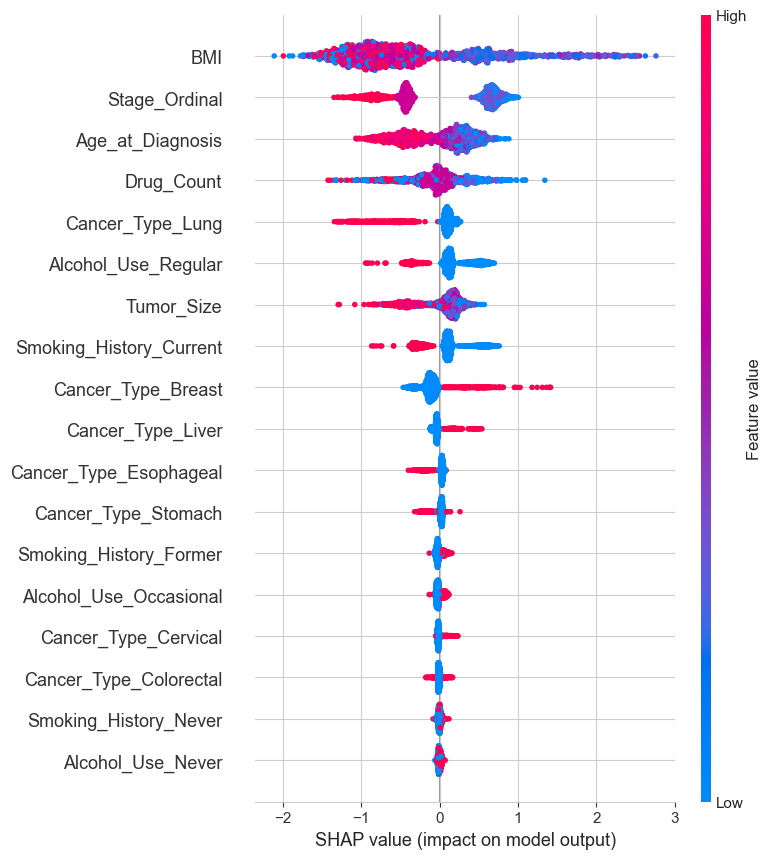

In [ ]:
import shap

# Train final model on full training set
final_pipeline = imbPipeline([
    ('preprocessor', preprocessor),
    ('smote', SMOTE(random_state=42)),
    ('feature_selection', SelectFromModel(CatBoostClassifier(verbose=0, random_state=42))),
    ('model', CatBoostClassifier(
        random_state=42, auto_class_weights='Balanced', verbose=0, depth=6, l2_leaf_reg=3))
])
final_pipeline.fit(X_train, y_train)

# Get predictions on validation set
y_val_proba = final_pipeline.predict_proba(X_val)[:, 1]
threshold = find_optimal_threshold(y_val, y_val_proba)
y_val_pred = (y_val_proba > threshold).astype(int)

# Identify misclassified deceased samples (False Negatives: actual 0, predicted 1)
fn_mask = (y_val == 0) & (y_val_pred == 1)
X_val_fn = X_val[fn_mask]

print(f"\nFalse Negatives (Deceased predicted Alive): {X_val_fn.shape[0]} samples")

# Transform features for SHAP explanation (only preprocessing part)
X_val_transformed = preprocessor.transform(X_val)
X_val_fn_transformed = preprocessor.transform(X_val_fn)

# Fit CatBoost model on transformed features only for SHAP
catboost_model = CatBoostClassifier(
    random_state=42, auto_class_weights='Balanced', verbose=0, depth=6, l2_leaf_reg=3)
catboost_model.fit(preprocessor.transform(X_train), y_train)

# SHAP explainer
explainer = shap.Explainer(catboost_model)
shap_values = explainer(X_val_fn_transformed)

# SHAP summary plot for false negatives
shap.summary_plot(shap_values, features=X_val_fn_transformed,
                  feature_names=final_pipeline.named_steps['preprocessor'].get_feature_names_out(),
                  max_display=20)



False Negatives (Deceased predicted Alive): 2348 samples
True Negatives (Correctly classified Deceased): 367 samples

SHAP Summary for False Negatives (Misclassified Deceased)


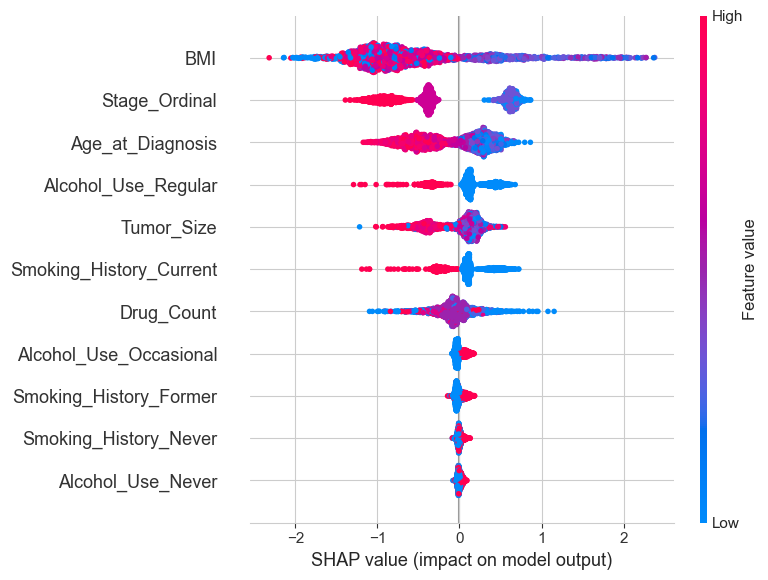


SHAP Summary for True Negatives (Correctly Classified Deceased)


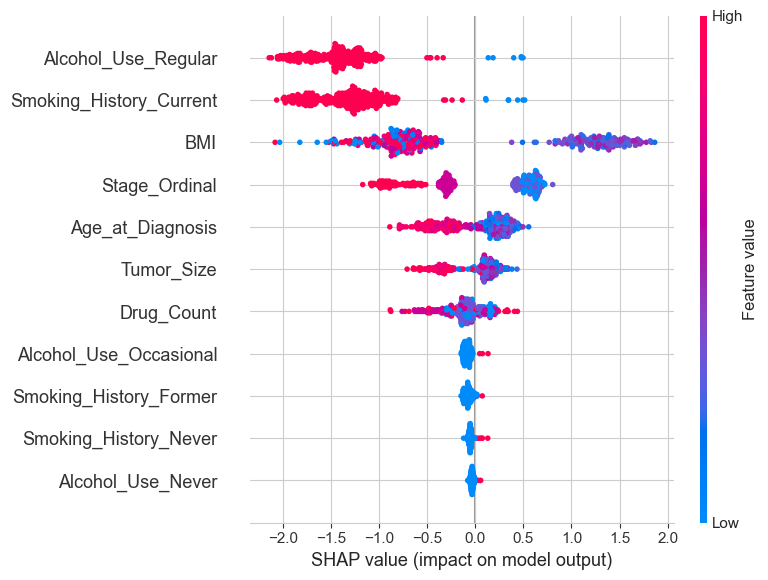

In [74]:
import shap
import numpy as np
import pandas as pd
from catboost import CatBoostClassifier
from imblearn.pipeline import Pipeline as imbPipeline
from imblearn.over_sampling import SMOTE
from sklearn.feature_selection import SelectFromModel

# Train final model on full training set
final_pipeline = imbPipeline([
    ('preprocessor', preprocessor),
    ('smote', SMOTE(random_state=42)),
    ('feature_selection', SelectFromModel(CatBoostClassifier(verbose=0, random_state=42))),
    ('model', CatBoostClassifier(
        random_state=42, 
        auto_class_weights='Balanced', 
        verbose=0, 
        depth=6, 
        l2_leaf_reg=3
    ))
])

final_pipeline.fit(X_train, y_train)

# Get predictions on validation set
y_val_proba = final_pipeline.predict_proba(X_val)[:, 1]
threshold = find_optimal_threshold(y_val, y_val_proba)
y_val_pred = (y_val_proba > threshold).astype(int)

# Identify False Negatives (Misclassified Deceased) & True Negatives (Correctly Classified Deceased)
fn_mask = (y_val == 0) & (y_val_pred == 1)  # False Negatives (misclassified as alive)
tn_mask = (y_val == 0) & (y_val_pred == 0)  # True Negatives (correctly classified as deceased)

X_val_fn = X_val[fn_mask]  # Features of misclassified deceased samples
X_val_tn = X_val[tn_mask]  # Features of correctly classified deceased samples

print(f"\nFalse Negatives (Deceased predicted Alive): {X_val_fn.shape[0]} samples")
print(f"True Negatives (Correctly classified Deceased): {X_val_tn.shape[0]} samples")

# Transform features for SHAP explanation (only preprocessing part)
X_val_transformed = preprocessor.transform(X_val)
X_val_fn_transformed = preprocessor.transform(X_val_fn)
X_val_tn_transformed = preprocessor.transform(X_val_tn)

# Fit CatBoost model on transformed features only for SHAP analysis
catboost_model = CatBoostClassifier(
    random_state=42, 
    auto_class_weights='Balanced', 
    verbose=0, 
    depth=6, 
    l2_leaf_reg=3
)
catboost_model.fit(preprocessor.transform(X_train), y_train)

# Initialize SHAP explainer
explainer = shap.Explainer(catboost_model)

# Compute SHAP values for misclassified and correctly classified deceased samples
shap_values_fn = explainer(X_val_fn_transformed)  # False Negatives
shap_values_tn = explainer(X_val_tn_transformed)  # True Negatives

# Generate SHAP summary plot for False Negatives
print("\nSHAP Summary for False Negatives (Misclassified Deceased)")
shap.summary_plot(
    shap_values_fn, 
    features=X_val_fn_transformed, 
    feature_names=final_pipeline.named_steps['preprocessor'].get_feature_names_out(), 
    max_display=20
)

# Generate SHAP summary plot for True Negatives
print("\nSHAP Summary for True Negatives (Correctly Classified Deceased)")
shap.summary_plot(
    shap_values_tn, 
    features=X_val_tn_transformed, 
    feature_names=final_pipeline.named_steps['preprocessor'].get_feature_names_out(), 
    max_display=20
)


In [55]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_predict
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from catboost import CatBoostClassifier
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer

# Load and prepare data
def prepare_data(use_smote=False):
    # Basic feature engineering
    df['Age_at_Diagnosis'] = (pd.to_datetime(df['Diagnosis_Date']) - pd.to_datetime(df['Birth_Date'])).dt.days / 365.25
    df['BMI'] = df['Weight'] / ((df['Height']/100)**2)
    df['Stage_Ordinal'] = df['Stage_at_Diagnosis'].map({'I':1, 'II':2, 'III':3, 'IV':4})
    df['Had_Surgery'] = df['Surgery_Date'].notna().astype(int)
    df['Had_Chemotherapy'] = df['Chemotherapy_Drugs'].notna().astype(int)
    
    # Select features
    features = [
        'Age_at_Diagnosis', 'BMI', 'Stage_Ordinal', 'Tumor_Size',
        'Had_Surgery', 'Had_Chemotherapy', 'Radiation_Sessions',
        'Immunotherapy', 'Targeted_Therapy', 'Recurrence_Status',
        'Urban_Rural', 'Insurance_Type', 'Cancer_Type',
        'Smoking_History', 'Alcohol_Use'
    ]
    
    # Preprocessing
    categorical_features = [
        'Urban_Rural', 'Insurance_Type', 'Cancer_Type',
        'Recurrence_Status', 'Immunotherapy', 'Targeted_Therapy',
        'Smoking_History', 'Alcohol_Use'
    ]
    
    numerical_features = [f for f in features if f not in categorical_features]
    
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', StandardScaler(), numerical_features),
            ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
        ],
        remainder='drop'
    )
    
    X = df[features]
    y = df['label']
    
    # Split data
    X_train, X_val, y_train, y_val = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y)
    
    # Apply SMOTE if requested
    if use_smote:
        smote = SMOTE(random_state=42)
        X_train, y_train = smote.fit_resample(
            preprocessor.fit_transform(X_train), y_train)
    else:
        X_train = preprocessor.fit_transform(X_train)
    
    X_val = preprocessor.transform(X_val)
    
    return X_train, X_val, y_train, y_val, preprocessor

# CatBoost training function
def train_catboost(X_train, y_train, X_val, y_val, params):
    model = CatBoostClassifier(
        **params,
        random_state=42,
        verbose=0,
        thread_count=-1
    )
    
    model.fit(X_train, y_train, eval_set=(X_val, y_val), early_stopping_rounds=50)
    return model

# Evaluation function
def evaluate_model(model, X, y, set_name):
    y_pred = model.predict(X)
    y_proba = model.predict_proba(X)[:, 1]
    
    print(f"\n{set_name} Evaluation:")
    print("Accuracy:", accuracy_score(y, y_pred))
    print("Precision:", precision_score(y, y_pred))
    print("Recall:", recall_score(y, y_pred))
    print("F1:", f1_score(y, y_pred))
    
    cm = confusion_matrix(y, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
               xticklabels=['Pred 0', 'Pred 1'],
               yticklabels=['Actual 0', 'Actual 1'])
    plt.title(f"{set_name} Confusion Matrix")
    plt.show()
    
    return {
        'accuracy': accuracy_score(y, y_pred),
        'precision': precision_score(y, y_pred),
        'recall': recall_score(y, y_pred),
        'f1': f1_score(y, y_pred)
    }

# Parameter grids to test
param_grids = [
    # Conservative settings (focus on deceased)
    {
        'iterations': 1000,
        'depth': 4,
        'learning_rate': 0.05,
        'l2_leaf_reg': 5,
        'scale_pos_weight': (len(y_train) - sum(y_train)) / sum(y_train),
        'auto_class_weights': 'Balanced'
    },
    # Balanced settings
    {
        'iterations': 800,
        'depth': 6,
        'learning_rate': 0.1,
        'l2_leaf_reg': 3,
        'scale_pos_weight': 1,
        'auto_class_weights': None
    },
    # Aggressive settings (focus on accuracy)
    {
        'iterations': 1200,
        'depth': 8,
        'learning_rate': 0.2,
        'l2_leaf_reg': 1,
        'scale_pos_weight': 0.5,
        'auto_class_weights': None
    }
]

# Test different approaches
results = []
for use_smote in [False, True]:
    for params in param_grids:
        print(f"\n{'='*50}")
        print(f"Testing with SMOTE={use_smote} and params: {params}")
        
        # Prepare data
        X_train, X_val, y_train, y_val, preprocessor = prepare_data(use_smote)
        
        # Train model
        model = train_catboost(X_train, y_train, X_val, y_val, params)
        
        # Evaluate
        train_metrics = evaluate_model(model, X_train, y_train, "Training")
        val_metrics = evaluate_model(model, X_val, y_val, "Validation")
        
        results.append({
            'approach': f"SMOTE={use_smote}, params={params['scale_pos_weight']}",
            'train_accuracy': train_metrics['accuracy'],
            'val_accuracy': val_metrics['accuracy'],
            'val_precision': val_metrics['precision'],
            'val_recall': val_metrics['recall'],
            'val_f1': val_metrics['f1']
        })

# Show all results
results_df = pd.DataFrame(results)
print("\nAll Results:")
print(results_df.sort_values('val_f1', ascending=False))


Testing with SMOTE=False and params: {'iterations': 1000, 'depth': 4, 'learning_rate': 0.05, 'l2_leaf_reg': 5, 'scale_pos_weight': 1.0589153335934451, 'auto_class_weights': 'Balanced'}


CatBoostError: only one of the parameters scale_pos_weight, class_weights, auto_class_weights should be initialized.